In [2]:
import collections
import sys
import os
import re
import time
import numpy as np
import pandas as pd

In [3]:
class StubLogger(object):
    def __getattr__(self, name):
        return self.log_print

    def log_print(self, msg, *args):
        print(msg % args)

LOGGER = StubLogger()
LOGGER.info("Hello %s!", "world")

Hello world!


In [4]:
import contextlib
import time

@contextlib.contextmanager
def elapsed_timer(message):
    start_time = time.time()
    yield
    LOGGER.info(message.format(time.time() - start_time))

# Evaluation mechanism

Evaluation Functions

In [5]:
def hitsAtK(user_ranks, k=10):
    return (user_ranks["rank"].notna() & (user_ranks["rank"] <= k)).sum(skipna=True)


def precisionAtK(user_ranks, k):
    precision = float(hitsAtK(user_ranks, k)) / k
    return precision


def recallAtK(user_ranks, k):
    recall = float(hitsAtK(user_ranks, k)) / user_ranks.shape[0]
    return recall


def averagePrecisionAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_correct_user_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]

    if k_correct_user_ranks.shape[0] > 0:
        #print k_correct_user_ranks
        score = 0.0
        for row in range(k_correct_user_ranks.shape[0]):
            tmp_user_ranks = k_correct_user_ranks.head(row + 1)
            row_k = k_correct_user_ranks.iloc[row]["rank"]
            score = score + precisionAtK(tmp_user_ranks, row_k)
        avgPrec = float(score) / min(user_ranks.shape[0], k)
    else:
        avgPrec = 0.0
    return avgPrec


def ndcgAtK(user_ranks, k):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1)


    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]["rank"].values

    ranks_idcg = dcg(np.arange(1, k_user_ranks.shape[0] + 1))
    ranks_dcg = dcg(k_ranks)

    ndcg = float(np.sum(ranks_dcg)) / np.sum(ranks_idcg)
    return ndcg


def topEventsAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    return pd.DataFrame({
        "event_id": k_user_ranks["event_id"].drop_duplicates().sort_values()
    })

In [6]:
def quickMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
    })


def basicMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })


def quadMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_50": [precisionAtK(user_ranks, 50)],
        "precision_at_20": [precisionAtK(user_ranks, 20)],
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "precision_at_5": [precisionAtK(user_ranks, 5)],
        "recall_at_50": [recallAtK(user_ranks, 50)],
        "recall_at_20": [recallAtK(user_ranks, 20)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "recall_at_5": [recallAtK(user_ranks, 5)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "ndcg_at_5": [ndcgAtK(user_ranks, 5)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })

In [7]:
def evalMetrics(rank_data, *, runMetricsPerUser=None):
    if runMetricsPerUser is None:
        runMetricsPerUser = basicMetricsPerUser

    user_metrics = rank_data.groupby("user_id").apply(runMetricsPerUser)
    top_events_at_10 = rank_data.groupby("user_id").apply(topEventsAtK, 10)
    top_events_at_20 = rank_data.groupby("user_id").apply(topEventsAtK, 20)

    metrics = dict()
    # Precision
    if "precision_at_50" in user_metrics.columns:
        precision_50 = user_metrics["precision_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_50"] = [precision_50]
    if "precision_at_20" in user_metrics.columns:
        precision_20 = user_metrics["precision_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_20"] = [precision_20]
    if "precision_at_10" in user_metrics.columns:
        precision_10 = user_metrics["precision_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_10"] = [precision_10]
    if "precision_at_5" in user_metrics.columns:
        precision_5 = user_metrics["precision_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_5"] = [precision_5]

    # Recall
    if "recall_at_50" in user_metrics.columns:
        recall_50 = user_metrics["recall_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_50"] = [recall_50]
    if "recall_at_20" in user_metrics.columns:
        recall_20 = user_metrics["recall_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_20"] = [recall_20]
    if "recall_at_10" in user_metrics.columns:
        recall_10 = user_metrics["recall_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_10"] = [recall_10]
    if "recall_at_5" in user_metrics.columns:
        recall_5 = user_metrics["recall_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_5"] = [recall_5]

    # F1 Score
    if "precision_at_50" in user_metrics.columns and "recall_at_50" in user_metrics.columns:
        if precision_50 + recall_50 > 0:
            f1_score_50 =  2 * ((precision_50 * recall_50) / (precision_50 + recall_50))
        else:
            f1_score_50 = 0.0
        metrics["f1_score_at_50"] = [f1_score_50]
    if "precision_at_20" in user_metrics.columns and "recall_at_20" in user_metrics.columns:
        if precision_20 + recall_20 > 0:
            f1_score_20 =  2 * ((precision_20 * recall_20) / (precision_20 + recall_20))
        else:
            f1_score_20 = 0.0
        metrics["f1_score_at_20"] = [f1_score_20]
    if "precision_at_10" in user_metrics.columns and "recall_at_10" in user_metrics.columns:
        if precision_10 + recall_10 > 0:
            f1_score_10 =  2 * ((precision_10 * recall_10) / (precision_10 + recall_10))
        else:
            f1_score_10 = 0.0
        metrics["f1_score_at_10"] = [f1_score_10]
    if "precision_at_5" in user_metrics.columns and "recall_at_5" in user_metrics.columns:
        if precision_5 + recall_5 > 0:
            f1_score_5 =  2 * ((precision_5 * recall_5) / (precision_5 + recall_5))
        else:
            f1_score_5 = 0.0
        metrics["f1_score_at_5"] = [f1_score_5]

    # NDCG@50
    if "ndcg_at_50" in user_metrics.columns:
        ndcg_50 = user_metrics["ndcg_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_50"] = [ndcg_50]
    # NDCG@20
    if "ndcg_at_20" in user_metrics.columns:
        ndcg_20 = user_metrics["ndcg_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_20"] = [ndcg_20]
    # NDCG@10
    if "ndcg_at_10" in user_metrics.columns:
        ndcg_10 = user_metrics["ndcg_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_10"] = [ndcg_10]
    
    if "ndcg_at_5" in user_metrics.columns:
        ndcg_5 = user_metrics["ndcg_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_5"] = [ndcg_5]
    # MAP@20
    if "avg_prec_at_20" in user_metrics.columns:
        map_at_20 = user_metrics["avg_prec_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_20"] = [map_at_20]
    # MAP@10
    if "avg_prec_at_10" in user_metrics.columns:
        map_at_10 = user_metrics["avg_prec_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_10"] = [map_at_10]

    # Mean Rank (calculated only over the rank_data without NA's)
    mean_ranks = rank_data["rank"].mean(skipna=True)
    if np.isnan(mean_ranks):
        mean_ranks = 0.0
    # User Coverage (it cannot be calculated here)
    user_coverage = 0.0
    # Event Coverage
    event_coverage_10 = float(top_events_at_10.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]
    event_coverage_20 = float(top_events_at_20.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]

    metrics["mean_ranks"] = [mean_ranks]
    metrics["user_coverage"] = [user_coverage]
    metrics["event_coverage_at_10"] = [event_coverage_10]
    metrics["event_coverage_at_20"] = [event_coverage_20]
    # This percentage of NA's only affects the mean_ranks metric,
    # the other metrics consider the NA's in the calculation
    metrics["perc_user_events_rank_NA"] = float(rank_data["rank"].isna().sum()) / rank_data.shape[0]
    
    return pd.DataFrame(metrics)


In [8]:
def definePastRSVPGroups(count_data, new_col_name):
    count_data["past_rsvps"] = np.nan
    freqs = count_data["freq"]

    count_data.loc[freqs <= 0, "past_rsvps"] = "0"
    count_data.loc[freqs <= 1, "past_rsvps"] = "1"
    count_data.loc[freqs <= 2, "past_rsvps"] = "2"
    count_data.loc[freqs <= 3, "past_rsvps"] = "3"
    count_data.loc[freqs <= 4, "past_rsvps"] = "4"
    count_data.loc[freqs <= 5, "past_rsvps"] = "5"
    count_data.loc[(6 <= freqs) & (freqs <= 10), "past_rsvps"] = "6-10"
    count_data.loc[(11 <= freqs) & (freqs <= 20), "past_rsvps"] = "11-20"
    count_data.loc[freqs > 20, "past_rsvps"] = ">20"

    count_data["past_rsvps"] = count_data["past_rsvps"].astype("category")
    count_data = count_data.rename(columns={"past_rsvps": new_col_name})

    return count_data


In [9]:
class EvaluatePartition(object):
    def __init__(self, partition_dir, *, 
                 runMetricsPerUser=None):
        self.partition_dir = partition_dir
        self.runMetricsPerUser = runMetricsPerUser
        if self.runMetricsPerUser is None:
            self.runMetricsPerUser = basicMetricsPerUser

        self.user_event_rsvp_test_filepath = os.path.join(self.partition_dir, "user-event-rsvp_test.tsv")
#         self.count_events_per_test_user_filepath = os.path.join(self.partition_dir, "count_events_per_test-user_train.tsv")
#         self.count_users_per_test_event_filepath = os.path.join(self.partition_dir, "count_users_per_test-event_train.tsv")
        
        self.user_event_rsvps_test = pd.read_csv(self.user_event_rsvp_test_filepath,
                                                 sep='\t', header=None, names=["user_id", "event_id"])
#         self.count_events_per_test_user = pd.read_csv(self.count_events_per_test_user_filepath,
#                                       sep='\t', header=None, names=["user_id", "freq"])
#         self.count_users_per_test_event = pd.read_csv(self.count_users_per_test_event_filepath,
#                                        sep='\t', header=None, names=["event_id", "freq"])

        self.map_user_event_rsvps_test = self._read_map_user_events_test(self.user_event_rsvps_test)
#         self.user_count = definePastRSVPGroups(self.count_events_per_test_user, "user_past_rsvps")
#         self.event_count = definePastRSVPGroups(self.count_users_per_test_event, "event_past_rsvps")
        
        print("users: {0}, events: {1}".format(self.user_event_rsvps_test["user_id"].drop_duplicates().count(),
                                               self.user_event_rsvps_test["event_id"].drop_duplicates().count()))
        
        self.group_evaluations = {
            "partition": None,
            "partition-user": None,
            "partition-event": None,
            "partition-user-event": None
        }

    def _read_map_user_events_test(self, user_event_rsvps):
        user_events = dict()
        for row in user_event_rsvps.itertuples():
            user_events.setdefault(row.user_id, set()).add(row.event_id)
        return user_events

    def add_evaluation(self, recommendation_filepath, group_vars, *,
                       partition, algorithm, model_params,
                       pre_process_user_id=None, pre_process_event_id=None,
                       runMetricsPerUser=None):
        if runMetricsPerUser is None:
            runMetricsPerUser = self.runMetricsPerUser

        relevant_ranks = self._select_relevant_ranks(recommendation_filepath,
                                                     pre_process_user_id=pre_process_user_id,
                                                     pre_process_event_id=pre_process_event_id)
        self._evaluate_ranked_data(relevant_ranks, group_vars,
                                   partition=partition, algorithm=algorithm, model_params=model_params,
                                   runMetricsPerUser=runMetricsPerUser)

    def _select_relevant_ranks(self, recommendation_filepath, *,
                               pre_process_user_id=None, pre_process_event_id=None):
        if pre_process_user_id is None:
            pre_process_user_id = lambda x: x
        if pre_process_event_id is None:
            pre_process_event_id = lambda x: x

        relevant_ranked_user_ids = list()
        relevant_ranked_event_ids = list()
        relevant_ranks = list()

        recommendations = pd.read_csv(recommendation_filepath, sep='\t',
                                      header=None, names=["user_id", "recommendation"])
        recommendations["user_id"] = pre_process_user_id(recommendations["user_id"])

        for row in recommendations.itertuples():
            # Get the relevant events per user
            new_event_ids_test = self.map_user_event_rsvps_test[row.user_id]
            ranked_events = set()

            # Check if the model was capable of predicting a ranked list or not
            #   There is a predicted value different from ''
            if len(row) > 1 and row.recommendation:
                ranked_event_list = row.recommendation.split(',')
                # Find the relevant events (from new_event_ids_test) in the ranked recommended list and get its ranks
                for i, recommendation_str in enumerate(ranked_event_list):
                    if ranked_event_list[i]:
                        # Separate the new_event_id from the predicted score (use only the 1st one)
                        recommendation = recommendation_str.split(':')
                        new_event_id = pre_process_event_id(int(recommendation[0]))
                        if new_event_id in new_event_ids_test:
                            relevant_ranked_user_ids.append(row.user_id)
                            relevant_ranked_event_ids.append(new_event_id)
                            relevant_ranks.append(i + 1)
                            ranked_events.add(new_event_id)

            # IDEA: If the Model was not capable of recommeding this event to the user we consider a NA rank
            #   * Therefore, we consider ranking larger that limit (e.g. 100) the same as didn't ranking any event to the user
            for relevant_event in new_event_ids_test:
                if relevant_event not in ranked_events:
                    relevant_ranked_user_ids.append(row.user_id)
                    relevant_ranked_event_ids.append(relevant_event)
                    relevant_ranks.append(np.nan)

        return pd.DataFrame({
            "user_id": relevant_ranked_user_ids,
            "event_id": relevant_ranked_event_ids,
            "rank": relevant_ranks
        })

    def _evaluate_ranked_data(self, relevant_ranks, group_vars, *,
                              partition, algorithm, model_params, runMetricsPerUser):
        rank_data = relevant_ranks

#         rank_data = pd.merge(rank_data, self.user_count[["user_id", "user_past_rsvps"]], on="user_id")
#         rank_data = pd.merge(rank_data, self.event_count[["event_id", "event_past_rsvps"]], on="event_id")
#         rank_data = rank_data.sort_values(by=["user_past_rsvps", "event_past_rsvps"])

        if group_vars == "partition":
            eval_rank_data = evalMetrics(rank_data, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user":
#             eval_rank_data = rank_data.groupby("user_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-event":
#             eval_rank_data = rank_data.groupby("event_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user-event":
#             eval_rank_data = rank_data.groupby(["user_past_rsvps", "event_past_rsvps"]).apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)

        # Add the partition name
        eval_rank_data["partition"] = partition

        eval_rank_data["algorithm"] = algorithm

        if model_params:
            eval_rank_data["model_params"] = model_params
        else:
            eval_rank_data["model_params"] = np.nan

        if self.group_evaluations[group_vars] is None:
            self.group_evaluations[group_vars] = pd.DataFrame()
        self.group_evaluations[group_vars] = pd.concat([self.group_evaluations[group_vars],
                                                        eval_rank_data], ignore_index=True)


## Frappe dataset path combiner

In [10]:
def frappe_file(*args):
    return os.path.join("../experiments/frappe", *args)

# Baseline results

# Proposed methods

## SAFMsatt_ds_ni
SAFMsatt with different scaling and normal-initialized semantics

In [15]:
frappe_safmsatt_ds_ni = EvaluatePartition("../data/frappe/")

users: 3387, events: 856


In [17]:
f = 64
h = 256
l = str(0.005)[2:]
result_dir = "SAFMmp_ds/shared-attention/F{0}H{1}L{2}B256R001/0314".format(f, h, l)
with elapsed_timer("{0}s - %s" % (result_dir,)):
    for e in range(10, 100 + 1, 10):
        result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
        with elapsed_timer("-- {0}s - %s" % (result_path,)):
            frappe_safmsatt_ds_ni.add_evaluation(
                frappe_file(result_path),
                "partition", partition=e, algorithm="SAFMsatt_ds_ni", model_params="0314F{0}H{1}L{2}B256R001".format(f, h, l))


-- 48.44501495361328s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E10R001.tsv
-- 31.399566411972046s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E20R001.tsv
-- 31.418614864349365s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E30R001.tsv
-- 31.715346813201904s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E40R001.tsv
-- 31.761428833007812s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E50R001.tsv
-- 32.142791986465454s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E60R001.tsv
-- 32.1033878326416s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E70R001.tsv
-- 32.1929075717926s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256E80R001.tsv
-- 32.258949518203735s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0314/SAFMsatt_F64H256L005B256

In [19]:
f = 64
h = 256
l = str(0.005)[2:]
result_dir = "SAFMmp_ds/shared-attention/F{0}H{1}L{2}B256R001/0315".format(f, h, l)
with elapsed_timer("{0}s - %s" % (result_dir,)):
    for e in range(10, 100 + 1, 10):
        result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
        with elapsed_timer("-- {0}s - %s" % (result_path,)):
            frappe_safmsatt_ds_ni.add_evaluation(
                frappe_file(result_path),
                "partition", partition=e, algorithm="SAFMsatt_ds_ni", model_params="0314F{0}H{1}L{2}B256R001".format(f, h, l))


-- 31.382532358169556s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E10R001.tsv
-- 30.76260542869568s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E20R001.tsv
-- 30.749308109283447s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E30R001.tsv
-- 30.950631618499756s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E40R001.tsv
-- 31.003896236419678s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E50R001.tsv
-- 30.95806074142456s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E60R001.tsv
-- 30.929286241531372s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E70R001.tsv
-- 31.064078330993652s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B256E80R001.tsv
-- 31.02300715446472s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0315/SAFMsatt_F64H256L005B2

In [20]:
frappe_safmsatt_ds_ni.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0          0.003071      0.030706        0.005583    0.056349    0.016117   
1          0.002982      0.029820        0.005422    0.060389    0.017674   
2          0.004340      0.043401        0.007891    0.070982    0.030483   
3          0.007056      0.070564        0.012830    0.083084    0.050904   
4          0.008975      0.089755        0.016319    0.091605    0.070440   
5          0.017774      0.177738        0.032316    0.121154    0.093443   
6          0.017774      0.177738        0.032316    0.130033    0.109753   
7          0.018335      0.183348        0.033336    0.140565    0.120651   
8          0.019988      0.199882        0.036342    0.151659    0.131054   
9          0.024033      0.240331        0.043696    0.158037    0.136356   
10         0.000561      0.005610        0.001020    0.009184    0.004174   
11         0.000827      0.008267        0.001503    0.019507    0.008966   
12         0.000502      0.005019        0.000913    0.013192    0.004151   
13         0.000561      0.005610        0.001020    0.012839    0.004349   
14         0.000531      0.005314        0.000966    0.012383    0.004316   
15         0.000709      0.007086        0.001288    0.011773    0.004781   
16         0.000679      0.006791        0.001235    0.011411    0.004712   
17         0.000768      0.007676        0.001396    0.010376    0.004637   
18         0.000827      0.008267        0.001503    0.010714    0.005069   
19         0.000827      0.008267        0.001503    0.010402    0.005158   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
0     0.012719   0.008118   0.007245   47.845197            0.0   
1     0.014326   0.010211   0.009373   45.038618            0.0   
2     0.018207   0.014209   0.010644   37.838076            0.0   
3     0.028763   0.021763   0.016206   35.061671            0.0   
4     0.037728   0.031423   0.021928   31.412351            0.0   
5     0.083311   0.059546   0.056541   28.845401            0.0   
6     0.088819   0.068682   0.063156   28.381378            0.0   
7     0.097755   0.078015   0.071627   27.110689            0.0   
8     0.110625   0.089110   0.082959   25.345546            0.0   
9     0.126560   0.094975   0.091995   24.137800            0.0   
10    0.002801   0.002292   0.001939   56.907051            0.0   
11    0.003734   0.003798   0.002397   49.941839            0.0   
12    0.002164   0.001830   0.001300   56.335354            0.0   
13    0.002637   0.002178   0.001710   58.913043            0.0   
14    0.002323   0.001967   0.001432   57.488938            0.0   
15    0.002971   0.002254   0.001786   59.280374            0.0   
16    0.002931   0.002272   0.001790   58.359801            0.0   
17    0.003046   0.002106   0.001696   60.417633            0.0   
18    0.003273   0.002307   0.001812   57.746835            0.0   
19    0.003226   0.002284   0.001757   59.041667            0.0   

    event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
0                    1.0                   1.0                  0.572778   
1                    1.0                   1.0                  0.564216   
2                    1.0                   1.0                  0.564216   
3                    1.0                   1.0                  0.554768   
4                    1.0                   1.0                  0.555359   
5                    1.0                   1.0                  0.547387   
6                    1.0                   1.0                  0.537053   
7                    1.0                   1.0                  0.533215   
8                    1.0                   1.0                  0.532625   
9                    1.0                   1.0                  0.532920   
10                   1.0                   1.0                  0.907883   
11                   1.0                   1.0                  0.

## SAFMsatt with kaiming-initialized semantics

In [11]:
frappe_safmsatt_ki = EvaluatePartition("../data/frappe/")

users: 3387, events: 856


In [13]:
f = 64
h = 256
for l in [str(l)[2:] for l in [0.005, 0.01]]:
    result_dir = "SAFMsatt_ki/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                frappe_safmsatt_ki.add_evaluation(
                    frappe_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt_ki", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 31.016597747802734s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E10R001.tsv
-- 31.344298362731934s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E20R001.tsv
-- 31.221383094787598s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E30R001.tsv
-- 31.518968105316162s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E40R001.tsv
-- 32.42241883277893s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E50R001.tsv
-- 34.915130853652954s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E60R001.tsv
-- 37.630268812179565s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E70R001.tsv
-- 31.27927017211914s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E80R001.tsv
-- 31.59172821044922s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E90R001.tsv
-- 31.449839115142822s - SAFMsatt_ki/F64H256L005B256R001/SAFMsatt_F64H256L005B256E100R001.tsv
324.39102053642273s - SAFMsatt_ki/F64H256L005B256R001
-- 31.325097322463

In [14]:
frappe_safmsatt_ki.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0          0.000295      0.002952        0.000537    0.005397    0.002197   
1          0.000443      0.004429        0.000805    0.007028    0.002943   
2          0.000650      0.006495        0.001181    0.009192    0.004741   
3          0.000768      0.007676        0.001396    0.011399    0.006082   
4          0.000856      0.008562        0.001557    0.012555    0.006398   
5          0.000886      0.008857        0.001610    0.012493    0.006497   
6          0.000886      0.008857        0.001610    0.012773    0.006916   
7          0.000650      0.006495        0.001181    0.011275    0.005172   
8          0.001004      0.010038        0.001825    0.011516    0.006268   
9          0.001151      0.011515        0.002094    0.013565    0.007043   
10         0.000590      0.005905        0.001074    0.009439    0.004356   
11         0.000531      0.005314        0.000966    0.015876    0.005587   
12         0.000650      0.006495        0.001181    0.014234    0.005188   
13         0.001476      0.014762        0.002684    0.020884    0.009398   
14         0.001240      0.012400        0.002255    0.015971    0.007646   
15         0.001358      0.013581        0.002469    0.017973    0.010621   
16         0.001624      0.016239        0.002952    0.020456    0.012794   
17         0.001831      0.018305        0.003328    0.021764    0.013396   
18         0.002657      0.026572        0.004831    0.026407    0.017942   
19         0.002569      0.025686        0.004670    0.026627    0.017645   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
0     0.001321   0.001066   0.000836   55.116959            0.0   
1     0.001850   0.001381   0.001094   56.691983            0.0   
2     0.002833   0.002240   0.001734   52.701107            0.0   
3     0.003739   0.003189   0.002569   55.160000            0.0   
4     0.003514   0.002792   0.002015   52.536585            0.0   
5     0.003419   0.002694   0.001840   49.938053            0.0   
6     0.004019   0.003310   0.002561   53.242424            0.0   
7     0.002669   0.002218   0.001550   54.005882            0.0   
8     0.003745   0.002600   0.001916   53.862162            0.0   
9     0.004689   0.003293   0.002665   51.882507            0.0   
10    0.002585   0.002075   0.001601   58.040115            0.0   
11    0.002171   0.002193   0.001265   52.036810            0.0   
12    0.002616   0.002165   0.001481   53.187638            0.0   
13    0.005838   0.004198   0.003272   49.454225            0.0   
14    0.005993   0.004489   0.004069   51.888361            0.0   
15    0.007229   0.006227   0.005317   48.960000            0.0   
16    0.008757   0.007640   0.006529   48.993506            0.0   
17    0.009625   0.008155   0.007099   45.598698            0.0   
18    0.013973   0.011317   0.010259   42.334728            0.0   
19    0.012906   0.010368   0.009088   41.536735            0.0   

    event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
0                    1.0                   1.0                  0.949513   
1                    1.0                   1.0                  0.930027   
2                    1.0                   1.0                  0.919988   
3                    1.0                   1.0                  0.896664   
4                    1.0                   1.0                  0.891054   
5                    1.0                   1.0                  0.899911   
6                    1.0                   1.0                  0.883082   
7                    1.0                   1.0                  0.899616   
8                    1.0                   1.0                  0.890759   
9                    1.0                   1.0                  0.886921   
10                   1.0                   1.0                  0.896959   
11                   1.0                   1.0                  0.

## SAFM ResidualConcatenation, has FeedForward

In [34]:
frappe_safmrcsn = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [35]:
h = 256
for f in [32, 64]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMrcsn"
#         with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(100, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMrcsn_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                frappe_safmrcsn.add_evaluation(frappe_file(result_path),
                    "partition", partition=e, algorithm="SAFMrcsn", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 15.686685800552368s - SAFMrcsn/SAFMrcsn_F32H256L005B256E100R001.tsv
-- 15.718398809432983s - SAFMrcsn/SAFMrcsn_F32H256L01B256E100R001.tsv
-- 15.687341928482056s - SAFMrcsn/SAFMrcsn_F32H256L02B256E100R001.tsv
-- 15.716742515563965s - SAFMrcsn/SAFMrcsn_F32H256L05B256E100R001.tsv
-- 15.688490629196167s - SAFMrcsn/SAFMrcsn_F64H256L005B256E100R001.tsv
-- 15.58945083618164s - SAFMrcsn/SAFMrcsn_F64H256L01B256E100R001.tsv
-- 15.629323244094849s - SAFMrcsn/SAFMrcsn_F64H256L02B256E100R001.tsv
-- 15.740587711334229s - SAFMrcsn/SAFMrcsn_F64H256L05B256E100R001.tsv


In [36]:
frappe_safmrcsn.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0         0.000827      0.008267        0.001503    0.003187   56.381862   
1         0.000679      0.006791        0.001235    0.002752   54.333333   
2         0.000059      0.000590        0.000107    0.000203   67.303318   
3         0.000650      0.006495        0.001181    0.002482   61.148208   
4         0.001653      0.016534        0.003006    0.006340   49.593193   
5         0.000738      0.007381        0.001342    0.003078   54.116190   
6         0.000827      0.008267        0.001503    0.003441   54.751866   
7         0.005049      0.050487        0.009179    0.018827   42.349459   

   user_coverage  event_coverage_at_10  event_coverage_at_20  \
0            0.0                   1.0                   1.0   
1            0.0                   1.0                   1.0   
2            0.0                   1.0                   1.0   
3            0.0                   1.0                   1.0   
4            0.0                   1.0                   1.0   
5            0.0                   1.0                   1.0   
6            0.0                   1.0                   1.0   
7            0.0                   1.0                   1.0   

   perc_user_events_rank_NA  partition algorithm         model_params  
0                  0.876292        100  SAFMrcsn  F32H256L005B256R001  
1                  0.866253        100  SAFMrcsn   F32H256L01B256R001  
2                  0.937703        100  SAFMrcsn   F32H256L02B256R001  
3                  0.818719        100  SAFMrcsn   F32H256L05B256R001  
4                  0.817833        100  SAFMrcsn  F64H256L005B256R001  
5                  0.844996        100  SAFMrcsn   F64H256L01B256R001  
6                  0.841748        100  SAFMrcsn   F64H256L02B256R001  
7                  0.481252        100  SAFMrcsn   F64H256L05B256R001

## SAFM ResidualConcatenation, no FeedForward

In [37]:
frappe_safmrcnf = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [38]:
for f in [32, 64, 128]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMrcnf"
#         with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(100, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMrcnf_F{0}L{1}B256E{2}R001.tsv".format(f, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                frappe_safmrcnf.add_evaluation(frappe_file(result_path),
                    "partition", partition=e, algorithm="SAFMrcnf", model_params="F{0}L{1}B256R001".format(f, l))


-- 15.793422222137451s - SAFMrcnf/SAFMrcnf_F32L005B256E100R001.tsv
-- 15.662383794784546s - SAFMrcnf/SAFMrcnf_F32L01B256E100R001.tsv
-- 15.685182332992554s - SAFMrcnf/SAFMrcnf_F32L02B256E100R001.tsv
-- 15.757630825042725s - SAFMrcnf/SAFMrcnf_F32L05B256E100R001.tsv
-- 15.7549467086792s - SAFMrcnf/SAFMrcnf_F64L005B256E100R001.tsv
-- 15.73545789718628s - SAFMrcnf/SAFMrcnf_F64L01B256E100R001.tsv
-- 15.65062141418457s - SAFMrcnf/SAFMrcnf_F64L02B256E100R001.tsv
-- 15.656038761138916s - SAFMrcnf/SAFMrcnf_F64L05B256E100R001.tsv
-- 15.708231925964355s - SAFMrcnf/SAFMrcnf_F128L005B256E100R001.tsv
-- 15.622301578521729s - SAFMrcnf/SAFMrcnf_F128L01B256E100R001.tsv
-- 15.755665063858032s - SAFMrcnf/SAFMrcnf_F128L02B256E100R001.tsv
-- 15.691174268722534s - SAFMrcnf/SAFMrcnf_F128L05B256E100R001.tsv


In [39]:
frappe_safmrcnf.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.000325      0.003248        0.000590    0.001339   48.970588   
1          0.000089      0.000886        0.000161    0.000508   60.503759   
2          0.000443      0.004429        0.000805    0.001871   45.521739   
3          0.000059      0.000590        0.000107    0.000182   60.836538   
4          0.000650      0.006495        0.001181    0.002541   54.851266   
5          0.000354      0.003543        0.000644    0.001325   54.661538   
6          0.000472      0.004724        0.000859    0.001933   58.897092   
7          0.003661      0.036611        0.006656    0.016444   51.143179   
8          0.000325      0.003248        0.000590    0.001149   60.082677   
9          0.000295      0.002952        0.000537    0.001459   55.861314   
10         0.002303      0.023029        0.004187    0.009006   57.858824   
11         0.000590      0.005905        0.001074    0.002621   74.474245   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0                   1.0                   1.0   
1             0.0                   1.0                   1.0   
2             0.0                   1.0                   1.0   
3             0.0                   1.0                   1.0   
4             0.0                   1.0                   1.0   
5             0.0                   1.0                   1.0   
6             0.0                   1.0                   1.0   
7             0.0                   1.0                   1.0   
8             0.0                   1.0                   1.0   
9             0.0                   1.0                   1.0   
10            0.0                   1.0                   1.0   
11            0.0                   1.0                   1.0   

    perc_user_events_rank_NA  partition algorithm      model_params  
0                   0.969885        100  SAFMrcnf   F32L005B256R001  
1                   0.960732        100  SAFMrcnf    F32L01B256R001  
2                   0.959256        100  SAFMrcnf    F32L02B256R001  
3                   0.938589        100  SAFMrcnf    F32L05B256R001  
4                   0.906702        100  SAFMrcnf   F64L005B256R001  
5                   0.923236        100  SAFMrcnf    F64L01B256R001  
6                   0.868025        100  SAFMrcnf    F64L02B256R001  
7                   0.738116        100  SAFMrcnf    F64L05B256R001  
8                   0.925007        100  SAFMrcnf  F128L005B256R001  
9                   0.919102        100  SAFMrcnf   F128L01B256R001  
10                  0.749040        100  SAFMrcnf   F128L02B256R001  
11                  0.833776        100  SAFMrcnf   F128L05B256R001

# Contrast methods

### Metric plot

In [44]:
import matplotlib.pyplot as plt

def plot12(dataframe):
    fig_recall_ndcg = plt.figure(figsize=[14.4, 8.0], dpi=300)
    ax_recall_ndcg = fig_recall_ndcg.subplots(nrows=3, ncols=4, sharex="col")

    for axes_i, embedding_size in enumerate([64, 128, 256]):
        for hi, hidden_size in enumerate([embedding_size * 2, embedding_size * 4]):
            ax_recall_j = hi * 2 + 0
            if axes_i == 0:
                ax_recall_ndcg[axes_i, ax_recall_j].set_title("Recall@10")
            if axes_i == 2:
                ax_recall_ndcg[axes_i, ax_recall_j].set_xlabel("Training Epochs")
            for learning_rate in [0.005, 0.01, 0.02, 0.05]:
                model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
                index = (dataframe["model_params"] == model_param)
                ax_recall_ndcg[axes_i, ax_recall_j].plot(dataframe.loc[index, "partition"],
                                                         dataframe.loc[index, "recall_at_10"],
                                                         label="lr={0}".format(str(learning_rate)))
            ax_recall_ndcg[axes_i, ax_recall_j].set_ylim(bottom=0.0)
            ax_recall_ndcg[axes_i, ax_recall_j].legend()

            ax_ndcg_j = hi * 2 + 1
            if axes_i == 0:
                ax_recall_ndcg[axes_i, ax_ndcg_j].set_title("nDCG@10")
            if axes_i == 2:
                ax_recall_ndcg[axes_i, ax_ndcg_j].set_xlabel("Training Epochs")
            for learning_rate in [0.005, 0.01, 0.02, 0.05]:
                model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
                index = (dataframe["model_params"] == model_param)
                ax_recall_ndcg[axes_i, ax_ndcg_j].plot(dataframe.loc[index, "partition"],
                                                       dataframe.loc[index, "ndcg_at_10"],
                                                       label="lr={0}".format(str(learning_rate)))
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_ylim(bottom=0.0)
            ax_recall_ndcg[axes_i, ax_ndcg_j].legend()

    return fig_recall_ndcg

## SFMsingle

In [21]:
frappe_sfmsingle = EvaluatePartition("../data/frappe/")

users: 3387, events: 856


In [26]:
for f in [256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "SFMsingle/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "SFMsingle_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        frappe_sfmsingle.add_evaluation(frappe_file(result_path),
                            "partition", partition=e, algorithm="SFMsingle",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 30.664706707000732s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E10R001.tsv
-- 30.4976704120636s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E20R001.tsv
-- 30.484787464141846s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E30R001.tsv
-- 30.449209690093994s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E40R001.tsv
-- 30.568345546722412s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E50R001.tsv
-- 30.61502695083618s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E60R001.tsv
-- 30.563404083251953s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E70R001.tsv
-- 30.587754011154175s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E80R001.tsv
-- 30.627485036849976s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E90R001.tsv
-- 30.793379306793213s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E100R001.tsv
305.85257720947266s - SFMsingle/F256H512L005B256R001
-- 30.799

In [27]:
frappe_sfmsingle.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0           0.000236      0.002362        0.000429    0.004093    0.001890   
1           0.000266      0.002657        0.000483    0.004293    0.002088   
2           0.000236      0.002362        0.000429    0.004264    0.001994   
3           0.000266      0.002657        0.000483    0.003991    0.001647   
4           0.000148      0.001476        0.000268    0.004085    0.002123   
5           0.000236      0.002362        0.000429    0.004520    0.001761   
6           0.000266      0.002657        0.000483    0.004574    0.002153   
7           0.000236      0.002362        0.000429    0.004851    0.002256   
8           0.000148      0.001476        0.000268    0.004763    0.002219   
9           0.000325      0.003248        0.000590    0.004478    0.002281   
10          0.000266      0.002657        0.000483    0.004767    0.002717   
11          0.000384      0.003838        0.000698    0.004523    0.002636   
12          0.000295      0.002952        0.000537    0.003756    0.001872   
13          0.000118      0.001181        0.000215    0.003532    0.001757   
14          0.000236      0.002362        0.000429    0.003743    0.001896   
15          0.000177      0.001771        0.000322    0.003332    0.001242   
16          0.000177      0.001771        0.000322    0.002764    0.001158   
17          0.000118      0.001181        0.000215    0.002874    0.001168   
18          0.000236      0.002362        0.000429    0.002881    0.001583   
19          0.000177      0.001771        0.000322    0.002657    0.001459   
20          0.000384      0.003838        0.000698    0.005934    0.003205   
21          0.000531      0.005314        0.000966    0.005717    0.003681   
22          0.000561      0.005610        0.001020    0.005633    0.003474   
23          0.000502      0.005019        0.000913    0.005375    0.003716   
24          0.000443      0.004429        0.000805    0.005411    0.003816   
25          0.000443      0.004429        0.000805    0.004739    0.002603   
26          0.000413      0.004133        0.000752    0.004530    0.002775   
27          0.000384      0.003838        0.000698    0.004602    0.002344   
28          0.000413      0.004133        0.000752    0.004425    0.002490   
29          0.000413      0.004133        0.000752    0.004447    0.002385   
..               ...           ...             ...         ...         ...   
210         0.000443      0.004429        0.000805    0.006354    0.003327   
211         0.000325      0.003248        0.000590    0.004723    0.002678   
212         0.000384      0.003838        0.000698    0.004331    0.002194   
213         0.000148      0.001476        0.000268    0.003836    0.001566   
214         0.000472      0.004724        0.000859    0.004574    0.003122   
215         0.000325      0.003248        0.000590    0.003958    0.001905   
216         0.000266      0.002657        0.000483    0.003858    0.002052   
217         0.000354      0.003543        0.000644    0.004106    0.001810   
218         0.000266      0.002657        0.000483    0.003815    0.001539   
219         0.000325      0.003248        0.000590    0.004027    0.002228   
220         0.000472      0.004724        0.000859    0.006437    0.003184   
221         0.000413      0.004133        0.000752    0.005806    0.002660   
222         0.000531      0.005314        0.000966    0.009014    0.004303   
223         0.000384      0.003838        0.000698    0.005700    0.003202   
224         0.000590      0.005905        0.001074    0.005359    0.003115   
225         0.000207      0.002067        0.000376    0.004039    0.002075   
226         0.000266      0.002657        0.000483    0.004453    0.002163   
227         0.000384      0.003838        0.000698    0.004579    0.002831   
228         0.000472      0.004724        0.000859    0.004600    0.002846   
229         0.000443      0

### Ploting metrics

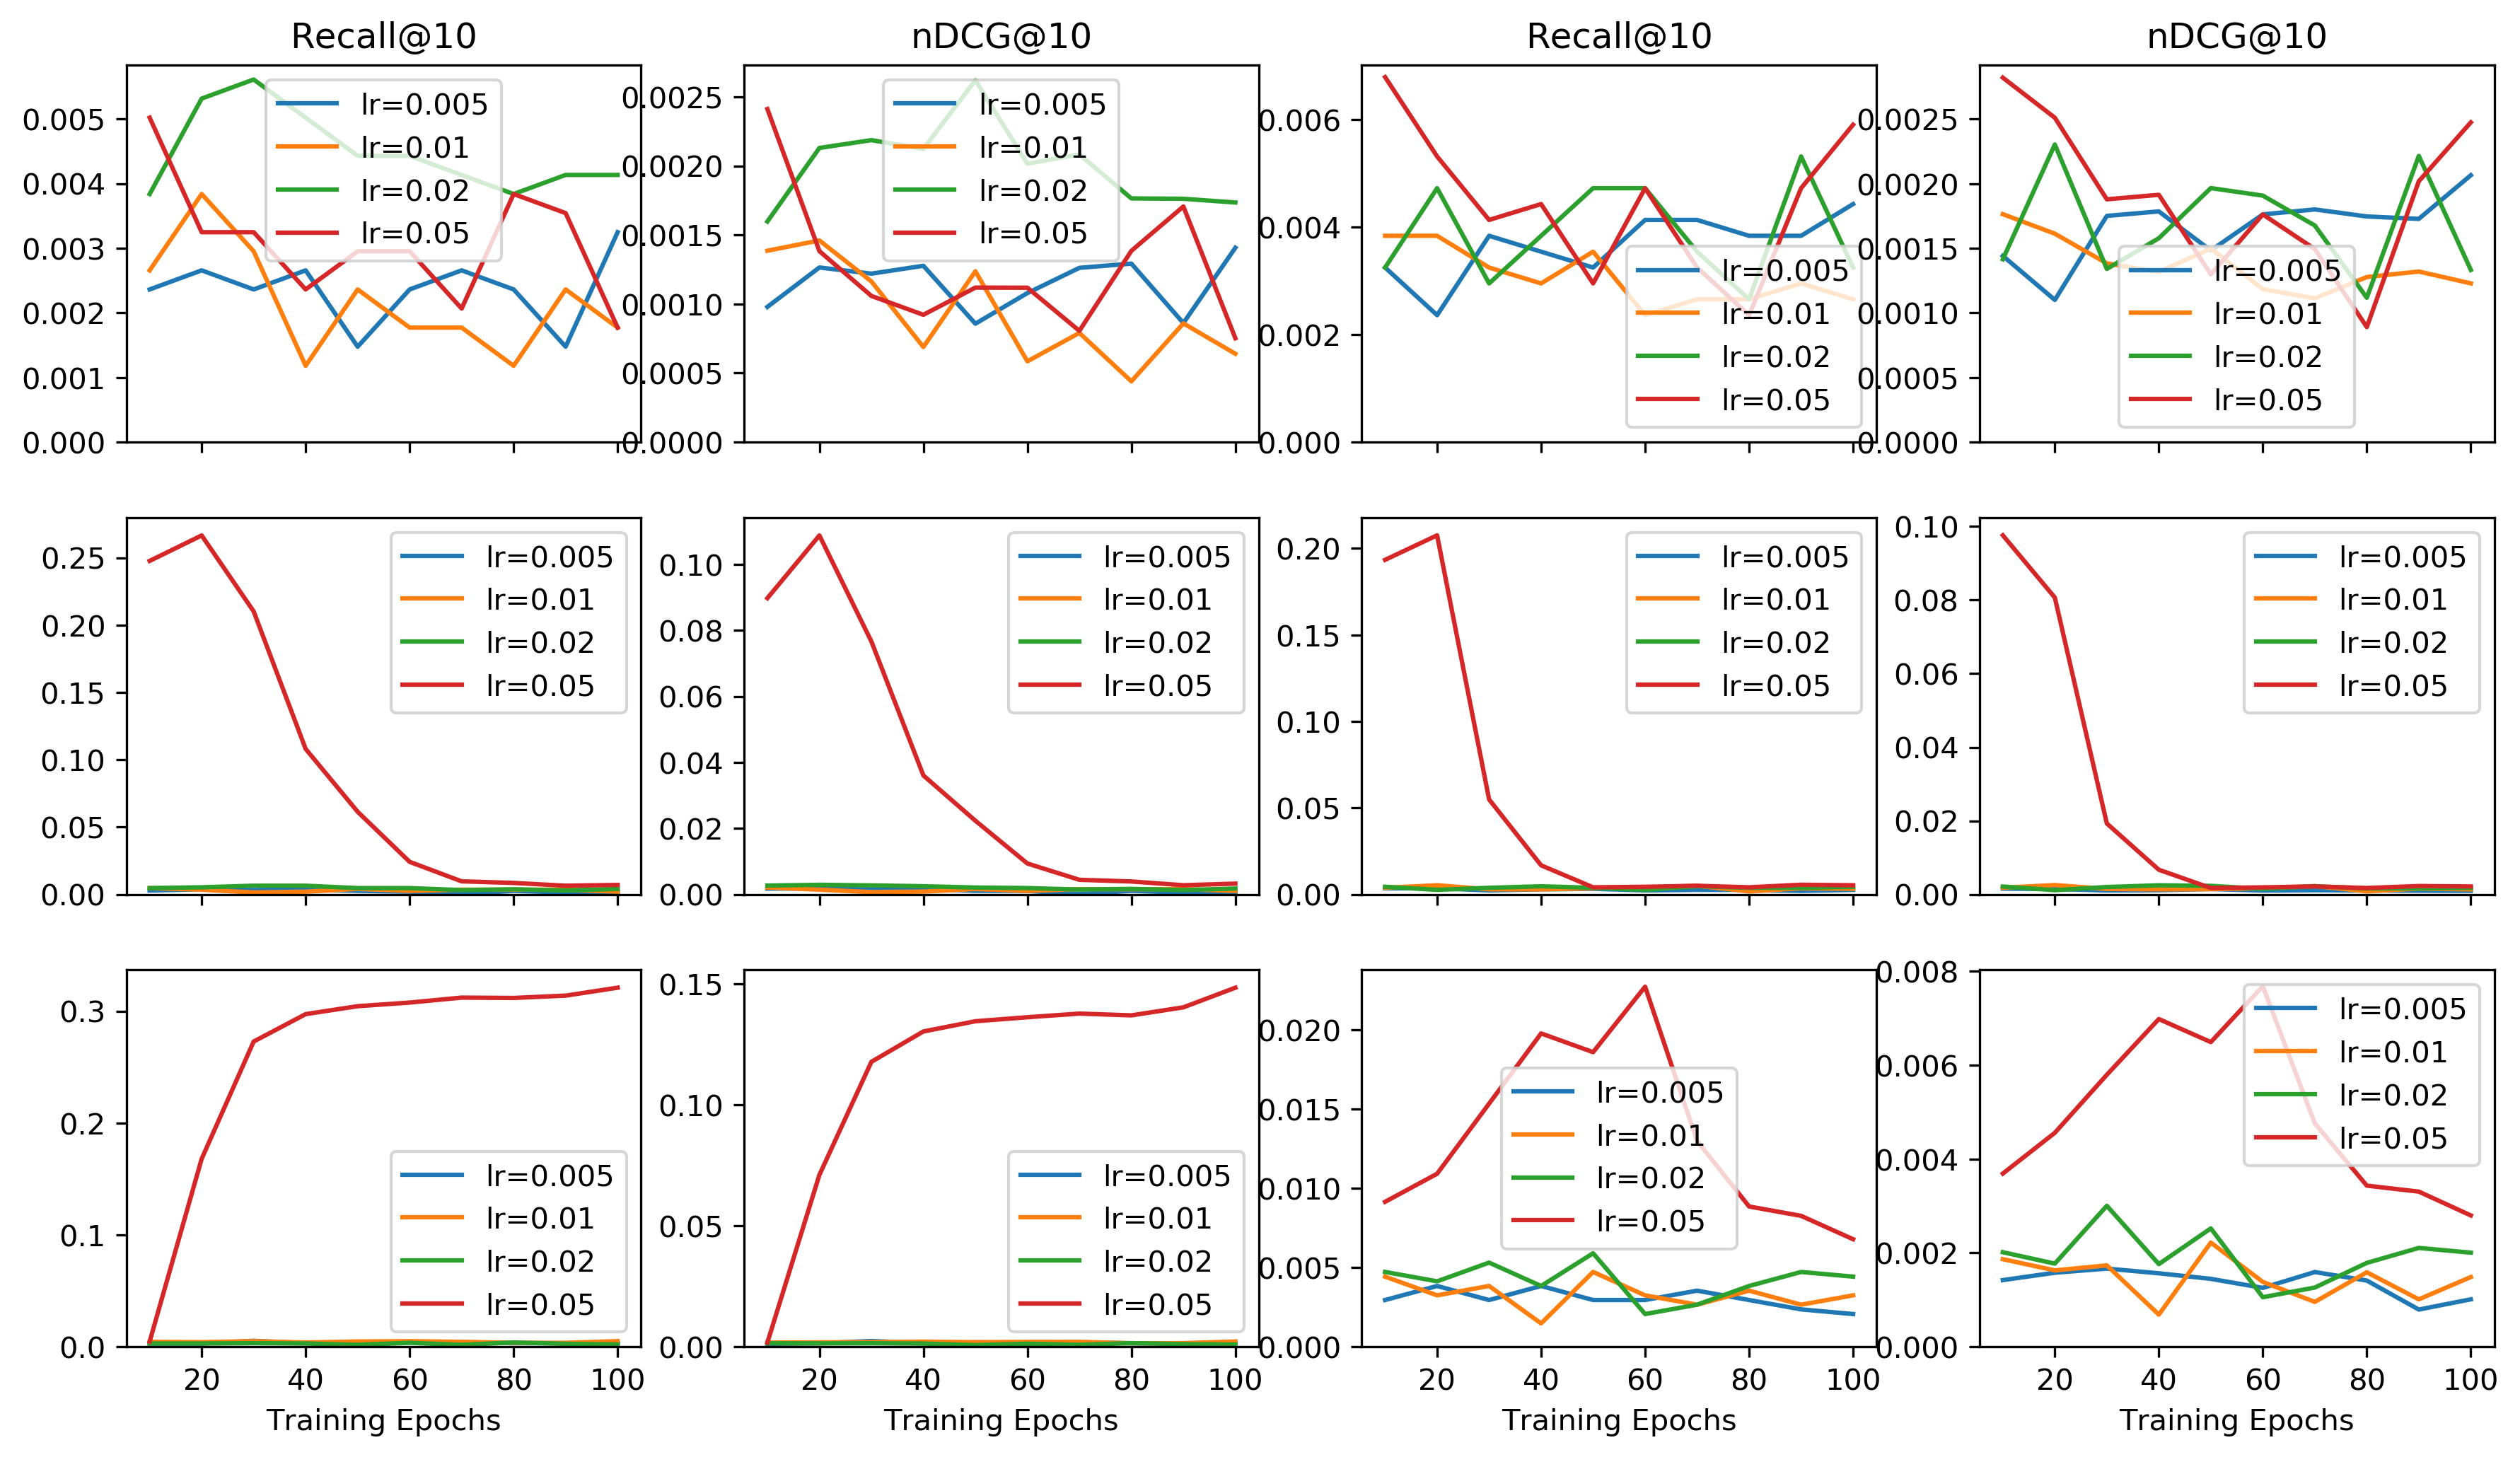

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_sfmsingle.group_evaluations["partition"]
frappe_sfmsingle_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = frappe_sfmsingle_fig.subplots(nrows=3, ncols=4, sharex="col")

for axes_i, embedding_size in enumerate([64, 128, 256]):
    for hi, hidden_size in enumerate([embedding_size * 2, embedding_size * 4]):
        ax_recall_j = hi * 2 + 0
        if axes_i == 0:
            ax_recall_ndcg[axes_i, ax_recall_j].set_title("Recall@10")
        if axes_i == 2:
            ax_recall_ndcg[axes_i, ax_recall_j].set_xlabel("Training Epochs")
        for learning_rate in [0.005, 0.01, 0.02, 0.05]:
            model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
            index = (dataframe["model_params"] == model_param)
            ax_recall_ndcg[axes_i, ax_recall_j].plot(dataframe.loc[index, "partition"],
                                                     dataframe.loc[index, "recall_at_10"],
                                                     label="lr={0}".format(str(learning_rate)))
        ax_recall_ndcg[axes_i, ax_recall_j].set_ylim(bottom=0.0)
        ax_recall_ndcg[axes_i, ax_recall_j].legend()

        ax_ndcg_j = hi * 2 + 1
        if axes_i == 0:
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_title("nDCG@10")
        if axes_i == 2:
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_xlabel("Training Epochs")
        for learning_rate in [0.005, 0.01, 0.02, 0.05]:
            model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
            index = (dataframe["model_params"] == model_param)
            ax_recall_ndcg[axes_i, ax_ndcg_j].plot(dataframe.loc[index, "partition"],
                                                   dataframe.loc[index, "ndcg_at_10"],
                                                   label="lr={0}".format(str(learning_rate)))
        ax_recall_ndcg[axes_i, ax_ndcg_j].set_ylim(bottom=0.0)
        ax_recall_ndcg[axes_i, ax_ndcg_j].legend()
    
frappe_sfmsingle_fig.show()

### Detecting F256H512 results

In [32]:
def filter_f256h512(df):
    return df[df["model_params"].str.startswith("F256H512")]

filter_f256h512(frappe_sfmsingle.group_evaluations["partition"])

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
160         0.000295      0.002952        0.000537    0.004285    0.002318   
161         0.000295      0.002952        0.000537    0.005246    0.002809   
162         0.000531      0.005314        0.000966    0.005535    0.003444   
163         0.000325      0.003248        0.000590    0.005639    0.003206   
164         0.000413      0.004133        0.000752    0.004907    0.002492   
165         0.000384      0.003838        0.000698    0.005454    0.002448   
166         0.000413      0.004133        0.000752    0.005293    0.002322   
167         0.000325      0.003248        0.000590    0.005350    0.002243   
168         0.000325      0.003248        0.000590    0.005487    0.002560   
169         0.000325      0.003248        0.000590    0.005451    0.002624   
170         0.000443      0.004429        0.000805    0.005973    0.002974   
171         0.000413      0.004133        0.000752    0.008246    0.003984   
172         0.000502      0.005019        0.000913    0.007188    0.003409   
173         0.000384      0.003838        0.000698    0.007525    0.003666   
174         0.000472      0.004724        0.000859    0.008167    0.003182   
175         0.000502      0.005019        0.000913    0.007449    0.003280   
176         0.000443      0.004429        0.000805    0.007314    0.003572   
177         0.000354      0.003543        0.000644    0.006188    0.002619   
178         0.000354      0.003543        0.000644    0.008270    0.003263   
179         0.000502      0.005019        0.000913    0.007372    0.003843   
180         0.000295      0.002952        0.000537    0.005678    0.002711   
181         0.000295      0.002952        0.000537    0.004064    0.002465   
182         0.000325      0.003248        0.000590    0.005540    0.002727   
183         0.000295      0.002952        0.000537    0.004595    0.002277   
184         0.000177      0.001771        0.000322    0.004987    0.001846   
185         0.000354      0.003543        0.000644    0.004689    0.002508   
186         0.000177      0.001771        0.000322    0.003984    0.001870   
187         0.000384      0.003838        0.000698    0.003728    0.002030   
188         0.000266      0.002657        0.000483    0.003955    0.001813   
189         0.000207      0.002067        0.000376    0.003879    0.001896   
190         0.000472      0.004724        0.000859    0.006499    0.003054   
191         0.016800      0.167995        0.030545    0.103935    0.088041   
192         0.027281      0.272808        0.049601    0.154194    0.137070   
193         0.029731      0.297313        0.054057    0.170400    0.151973   
194         0.030440      0.304399        0.055345    0.177709    0.157315   
195         0.030765      0.307647        0.055936    0.180256    0.159548   
196         0.031208      0.312076        0.056741    0.181600    0.160250   
197         0.031178      0.311780        0.056687    0.182054    0.159755   
198         0.031385      0.313847        0.057063    0.185605    0.162967   
199         0.032093      0.320933        0.058351    0.192127    0.169322   

     ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
160    0.001231   0.001015   0.000733   54.201493            0.0   
161    0.001475   0.001400   0.001039   54.582192            0.0   
162    0.002385   0.001761   0.001502   54.051948            0.0   
163    0.001506   0.001415   0.000957   52.552147            0.0   
164    0.001837   0.001321   0.001150   55.619355            0.0   
165    0.001654   0.001227   0.001024   53.668605            0.0   
166    0.001876   0.001334   0.001213   57.760870            0.0   
167    0.001464   0.001132   0.000940   52.142857            0.0   
168    0.001477   0.001221   0.000943   54.401163            0.0   
169    0.001547   0.001306   0.001033   52.880503            0.0   
170    0.001740   0.001299   0.000978   56.251208         

## SFMdual

In [33]:
frappe_sfmdual = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [36]:
for f in [64, 128, 256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "SFMdual/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "SFMdual_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        frappe_sfmdual.add_evaluation(frappe_file(result_path),
                            "partition", partition=e, algorithm="SFMdual",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 16.104753255844116s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E10R001.tsv
-- 16.15156888961792s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E20R001.tsv
-- 16.188783884048462s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E30R001.tsv
-- 16.2059223651886s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E40R001.tsv
-- 15.951607465744019s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E50R001.tsv
-- 16.079445362091064s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E60R001.tsv
-- 16.057514905929565s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E70R001.tsv
-- 16.087687492370605s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E80R001.tsv
-- 16.08465075492859s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E90R001.tsv
-- 16.1072039604187s - SFMdual/F64H128L005B256R001/SFMdual_F64H128L005B256E100R001.tsv
161.02017331123352s - SFMdual/F64H128L005B256R001
-- 16.096177101135254s - SFMdual/F64H128L01B256R001/SFMdual_F64H128L01B256E

-- 15.9743070602417s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E10R001.tsv
-- 15.994366645812988s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E20R001.tsv
-- 15.975705862045288s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E30R001.tsv
-- 15.961832761764526s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E40R001.tsv
-- 16.005242586135864s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E50R001.tsv
-- 16.01308512687683s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E60R001.tsv
-- 15.953482627868652s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E70R001.tsv
-- 15.977014780044556s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E80R001.tsv
-- 15.998396635055542s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E90R001.tsv
-- 15.955212593078613s - SFMdual/F128H256L01B256R001/SFMdual_F128H256L01B256E100R001.tsv
159.80951070785522s - SFMdual/F128H256L01B256R001
-- 15.98131251335144s - SFMdual/F128H256L02B256R001/SFMdual_F128H256L02B

-- 16.028268337249756s - SFMdual/F256H512L01B256R001/SFMdual_F256H512L01B256E100R001.tsv
160.25640487670898s - SFMdual/F256H512L01B256R001
-- 15.948112487792969s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E10R001.tsv
-- 15.997685670852661s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E20R001.tsv
-- 16.01715350151062s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E30R001.tsv
-- 15.975232362747192s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E40R001.tsv
-- 15.953055143356323s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E50R001.tsv
-- 15.979023933410645s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E60R001.tsv
-- 15.97856330871582s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E70R001.tsv
-- 15.985267400741577s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E80R001.tsv
-- 15.984869956970215s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L02B256E90R001.tsv
-- 15.959784030914307s - SFMdual/F256H512L02B256R001/SFMdual_F256H512L0

In [37]:
frappe_sfmdual.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0           0.004252      0.042516        0.007730    0.017856   40.089666   
1           0.006968      0.069678        0.012669    0.048344   44.275896   
2           0.004842      0.048420        0.008804    0.017585   44.687728   
3           0.001033      0.010334        0.001879    0.004650   48.020316   
4           0.000738      0.007381        0.001342    0.003385   50.630769   
5           0.000915      0.009153        0.001664    0.003780   49.526104   
6           0.000915      0.009153        0.001664    0.003898   48.462810   
7           0.000915      0.009153        0.001664    0.003711   49.180672   
8           0.000768      0.007676        0.001396    0.003338   52.474308   
9           0.000827      0.008267        0.001503    0.003460   48.638767   
10          0.003159      0.031591        0.005744    0.013053   40.603408   
11          0.004045      0.040449        0.007354    0.016925   44.687065   
12          0.002628      0.026277        0.004778    0.011959   49.106849   
13          0.002126      0.021258        0.003865    0.009711   50.590713   
14          0.001270      0.012696        0.002308    0.005246   54.291486   
15          0.001004      0.010038        0.001825    0.004243   54.610687   
16          0.000620      0.006200        0.001127    0.002846   57.437500   
17          0.000384      0.003838        0.000698    0.002350   58.000000   
18          0.000620      0.006200        0.001127    0.002676   54.795724   
19          0.000561      0.005610        0.001020    0.002556   56.439825   
20          0.006053      0.060526        0.011005    0.024179   36.415713   
21          0.026159      0.261588        0.047562    0.140411   23.659459   
22          0.021435      0.214349        0.038973    0.096663   25.391328   
23          0.015914      0.159138        0.028934    0.067316   28.623328   
24          0.010038      0.100384        0.018252    0.042136   35.160440   
25          0.007499      0.074993        0.013635    0.030157   41.655292   
26          0.006289      0.062888        0.011434    0.027532   43.852746   
27          0.005314      0.053144        0.009663    0.021157   46.434219   
28          0.004458      0.044582        0.008106    0.018844   48.682779   
29          0.003277      0.032772        0.005959    0.014431   49.948109   
..               ...           ...             ...         ...         ...   
210         0.001535      0.015353        0.002791    0.007160   51.632497   
211         0.000679      0.006791        0.001235    0.003230   41.463557   
212         0.001447      0.014467        0.002630    0.006121   41.030801   
213         0.002421      0.024210        0.004402    0.009527   47.530030   
214         0.005108      0.051078        0.009287    0.020242   45.009816   
215         0.002037      0.020372        0.003704    0.008404   53.146057   
216         0.001004      0.010038        0.001825    0.004916   59.133820   
217         0.001092      0.010924        0.001986    0.004558   57.778656   
218         0.000915      0.009153        0.001664    0.003868   53.553471   
219         0.000945      0.009448        0.001718    0.004018   53.714885   
220         0.000413      0.004133        0.000752    0.001986   53.228000   
221         0.000443      0.004429        0.000805    0.001994   52.450413   
222         0.000443      0.004429        0.000805    0.002245   51.471429   
223         0.000531      0.005314        0.000966    0.002609   55.409502   
224         0.010038      0.100384        0.018252    0.041029   34.015945   
225         0.017508      0.175081        0.031833    0.096296   26.632314   
226         0.023118      0.231178        0.042032    0.128489   24.983534   
227         0.022025      0.220254        0.040046    0.124534   26.978934   
228         0.024978      0.249779        0.045414    0.130059   26.550725   
229         0.020608      0

### Ploting metrics

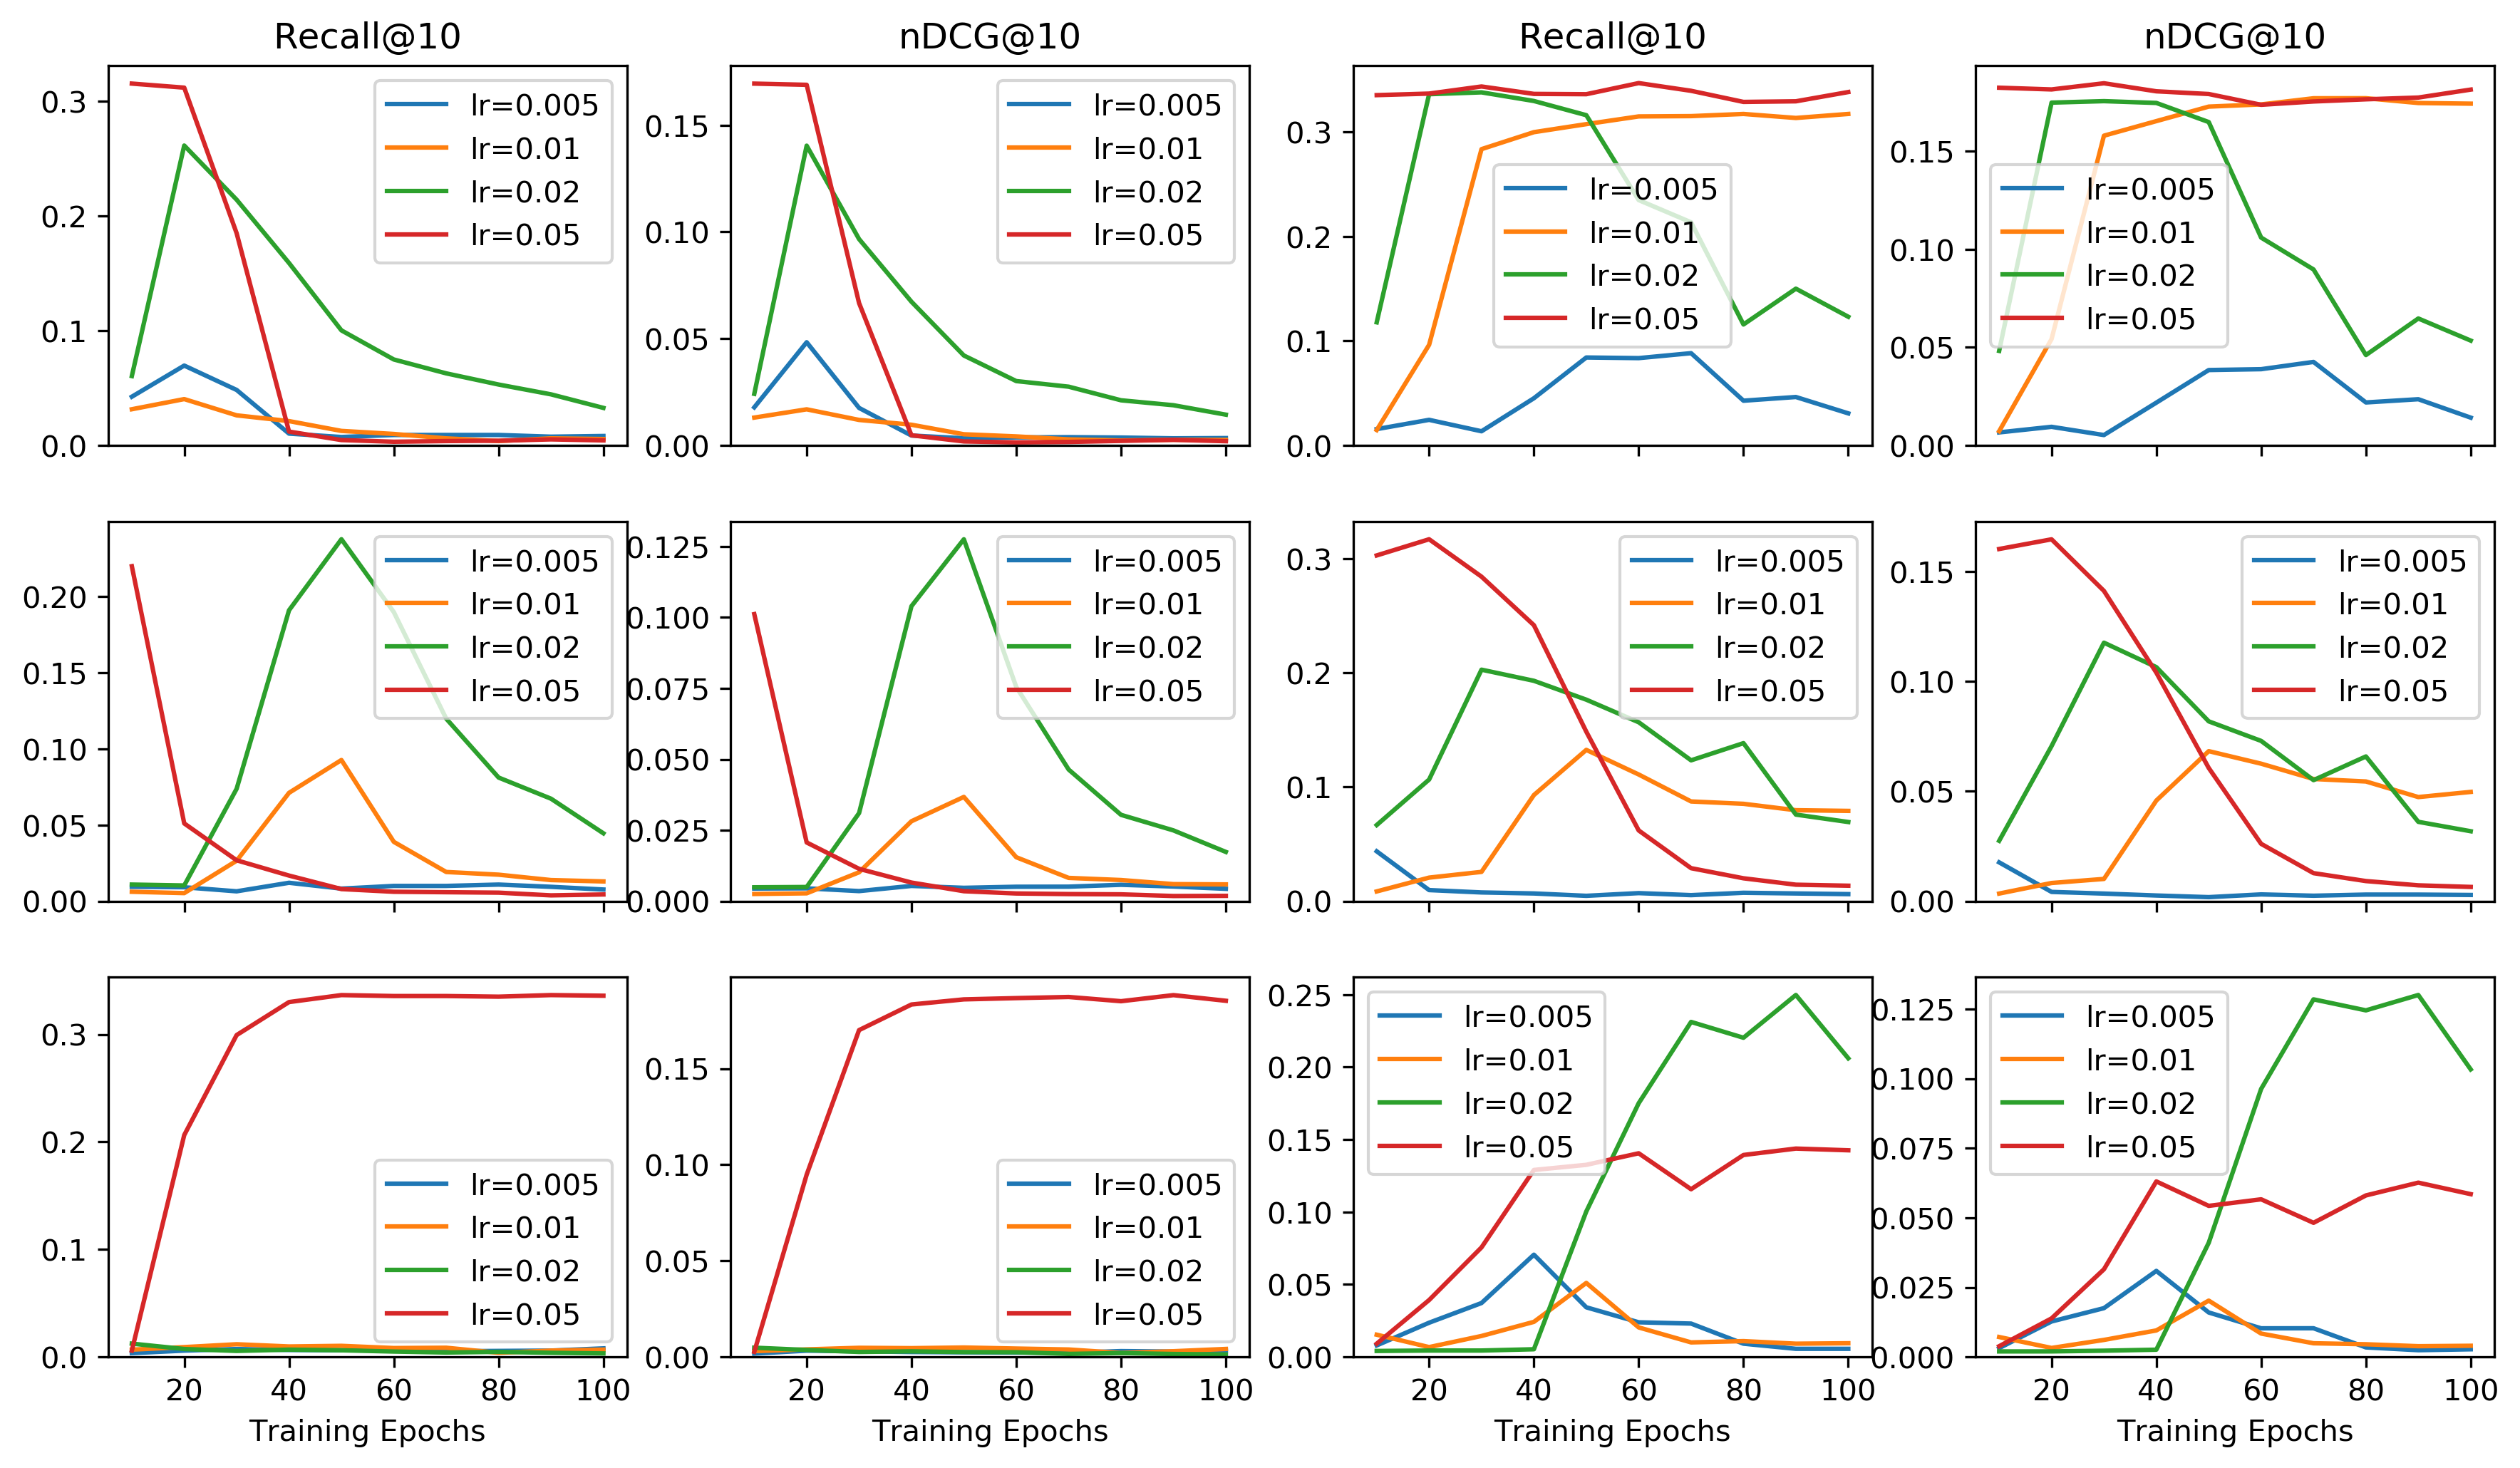

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_sfmdual.group_evaluations["partition"]
frappe_sfmdual_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = frappe_sfmdual_fig.subplots(nrows=3, ncols=4, sharex="col")

for axes_i, embedding_size in enumerate([64, 128, 256]):
    for hi, hidden_size in enumerate([embedding_size * 2, embedding_size * 4]):
        ax_recall_j = hi * 2 + 0
        if axes_i == 0:
            ax_recall_ndcg[axes_i, ax_recall_j].set_title("Recall@10")
        if axes_i == 2:
            ax_recall_ndcg[axes_i, ax_recall_j].set_xlabel("Training Epochs")
        for learning_rate in [0.005, 0.01, 0.02, 0.05]:
            model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
            index = (dataframe["model_params"] == model_param)
            ax_recall_ndcg[axes_i, ax_recall_j].plot(dataframe.loc[index, "partition"],
                                                     dataframe.loc[index, "recall_at_10"],
                                                     label="lr={0}".format(str(learning_rate)))
        ax_recall_ndcg[axes_i, ax_recall_j].set_ylim(bottom=0.0)
        ax_recall_ndcg[axes_i, ax_recall_j].legend()

        ax_ndcg_j = hi * 2 + 1
        if axes_i == 0:
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_title("nDCG@10")
        if axes_i == 2:
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_xlabel("Training Epochs")
        for learning_rate in [0.005, 0.01, 0.02, 0.05]:
            model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
            index = (dataframe["model_params"] == model_param)
            ax_recall_ndcg[axes_i, ax_ndcg_j].plot(dataframe.loc[index, "partition"],
                                                   dataframe.loc[index, "ndcg_at_10"],
                                                   label="lr={0}".format(str(learning_rate)))
        ax_recall_ndcg[axes_i, ax_ndcg_j].set_ylim(bottom=0.0)
        ax_recall_ndcg[axes_i, ax_ndcg_j].legend()
    
frappe_sfmdual_fig.show()

## TAFMsingle

In [39]:
frappe_tafmsingle = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [40]:
for f in [64, 128, 256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "TAFMsingle/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "TAFMsingle_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
#                     with elapsed_timer("-- {0}s - %s" % (result_path,)):
                    frappe_tafmsingle.add_evaluation(frappe_file(result_path),
                        "partition", partition=e, algorithm="TAFMsingle",
                        model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


161.80522108078003s - TAFMsingle/F64H128L005B256R001
160.19236254692078s - TAFMsingle/F64H128L01B256R001
161.78198075294495s - TAFMsingle/F64H128L02B256R001
161.71043753623962s - TAFMsingle/F64H128L05B256R001
161.90813374519348s - TAFMsingle/F64H256L005B256R001
162.47683334350586s - TAFMsingle/F64H256L01B256R001
162.13535356521606s - TAFMsingle/F64H256L02B256R001
162.28883910179138s - TAFMsingle/F64H256L05B256R001
162.47868275642395s - TAFMsingle/F128H256L005B256R001
162.32700300216675s - TAFMsingle/F128H256L01B256R001
161.54037070274353s - TAFMsingle/F128H256L02B256R001
161.99297642707825s - TAFMsingle/F128H256L05B256R001
161.9614188671112s - TAFMsingle/F128H512L005B256R001
161.874609708786s - TAFMsingle/F128H512L01B256R001
162.12209486961365s - TAFMsingle/F128H512L02B256R001
162.2950382232666s - TAFMsingle/F128H512L05B256R001
162.11883735656738s - TAFMsingle/F256H512L005B256R001
162.25904059410095s - TAFMsingle/F256H512L01B256R001
162.14273118972778s - TAFMsingle/F256H512L02B256R001


In [41]:
frappe_tafmsingle.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0           0.000709      0.007086        0.001288    0.003381   50.687500   
1           0.000384      0.003838        0.000698    0.001994   55.301508   
2           0.000531      0.005314        0.000966    0.002888   59.132597   
3           0.000413      0.004133        0.000752    0.002083   51.860465   
4           0.000502      0.005019        0.000913    0.002352   49.456954   
5           0.000590      0.005905        0.001074    0.002534   51.672840   
6           0.000531      0.005314        0.000966    0.002787   53.145455   
7           0.000354      0.003543        0.000644    0.001948   52.111111   
8           0.000502      0.005019        0.000913    0.002281   46.496503   
9           0.000502      0.005019        0.000913    0.002713   48.975460   
10          0.000650      0.006495        0.001181    0.003692   53.328413   
11          0.000797      0.007972        0.001449    0.003639   47.873171   
12          0.000531      0.005314        0.000966    0.002281   49.866310   
13          0.000561      0.005610        0.001020    0.002079   48.260355   
14          0.000590      0.005905        0.001074    0.002570   49.017045   
15          0.000354      0.003543        0.000644    0.001738   47.284884   
16          0.000650      0.006495        0.001181    0.002748   48.402299   
17          0.000590      0.005905        0.001074    0.002312   48.398844   
18          0.000561      0.005610        0.001020    0.002093   47.369697   
19          0.000590      0.005905        0.001074    0.002394   47.793939   
20          0.015117      0.151166        0.027485    0.085641   31.132192   
21          0.025066      0.250664        0.045575    0.133879   24.662276   
22          0.019722      0.197225        0.035859    0.084876   28.031059   
23          0.008710      0.087098        0.015836    0.039872   34.510703   
24          0.005610      0.056097        0.010199    0.026372   41.617937   
25          0.004281      0.042811        0.007784    0.018041   44.581818   
26          0.002657      0.026572        0.004831    0.009908   49.108645   
27          0.002539      0.025391        0.004617    0.009337   53.142320   
28          0.002037      0.020372        0.003704    0.007374   55.925156   
29          0.001712      0.017124        0.003114    0.006292   58.397141   
..               ...           ...             ...         ...         ...   
210         0.000679      0.006791        0.001235    0.002978   41.878981   
211         0.000531      0.005314        0.000966    0.001937   45.603175   
212         0.000590      0.005905        0.001074    0.002445   52.116592   
213         0.000709      0.007086        0.001288    0.002624   52.482301   
214         0.000295      0.002952        0.000537    0.001287   53.513274   
215         0.000354      0.003543        0.000644    0.001808   55.649402   
216         0.000413      0.004133        0.000752    0.001660   53.759804   
217         0.000413      0.004133        0.000752    0.001760   56.962025   
218         0.000236      0.002362        0.000429    0.001124   58.163551   
219         0.000354      0.003543        0.000644    0.001546   57.510101   
220         0.000974      0.009743        0.001771    0.004331   52.475655   
221         0.001329      0.013286        0.002416    0.005048   64.975000   
222         0.000502      0.005019        0.000913    0.002031   62.584962   
223         0.000679      0.006791        0.001235    0.002532   60.158537   
224         0.000768      0.007676        0.001396    0.003214   55.711022   
225         0.000650      0.006495        0.001181    0.002423   55.759478   
226         0.000709      0.007086        0.001288    0.002736   51.885015   
227         0.000620      0.006200        0.001127    0.002518   48.603469   
228         0.000561      0.005610        0.001020    0.002240   48.080683   
229         0.000620      0

### Ploting metrics

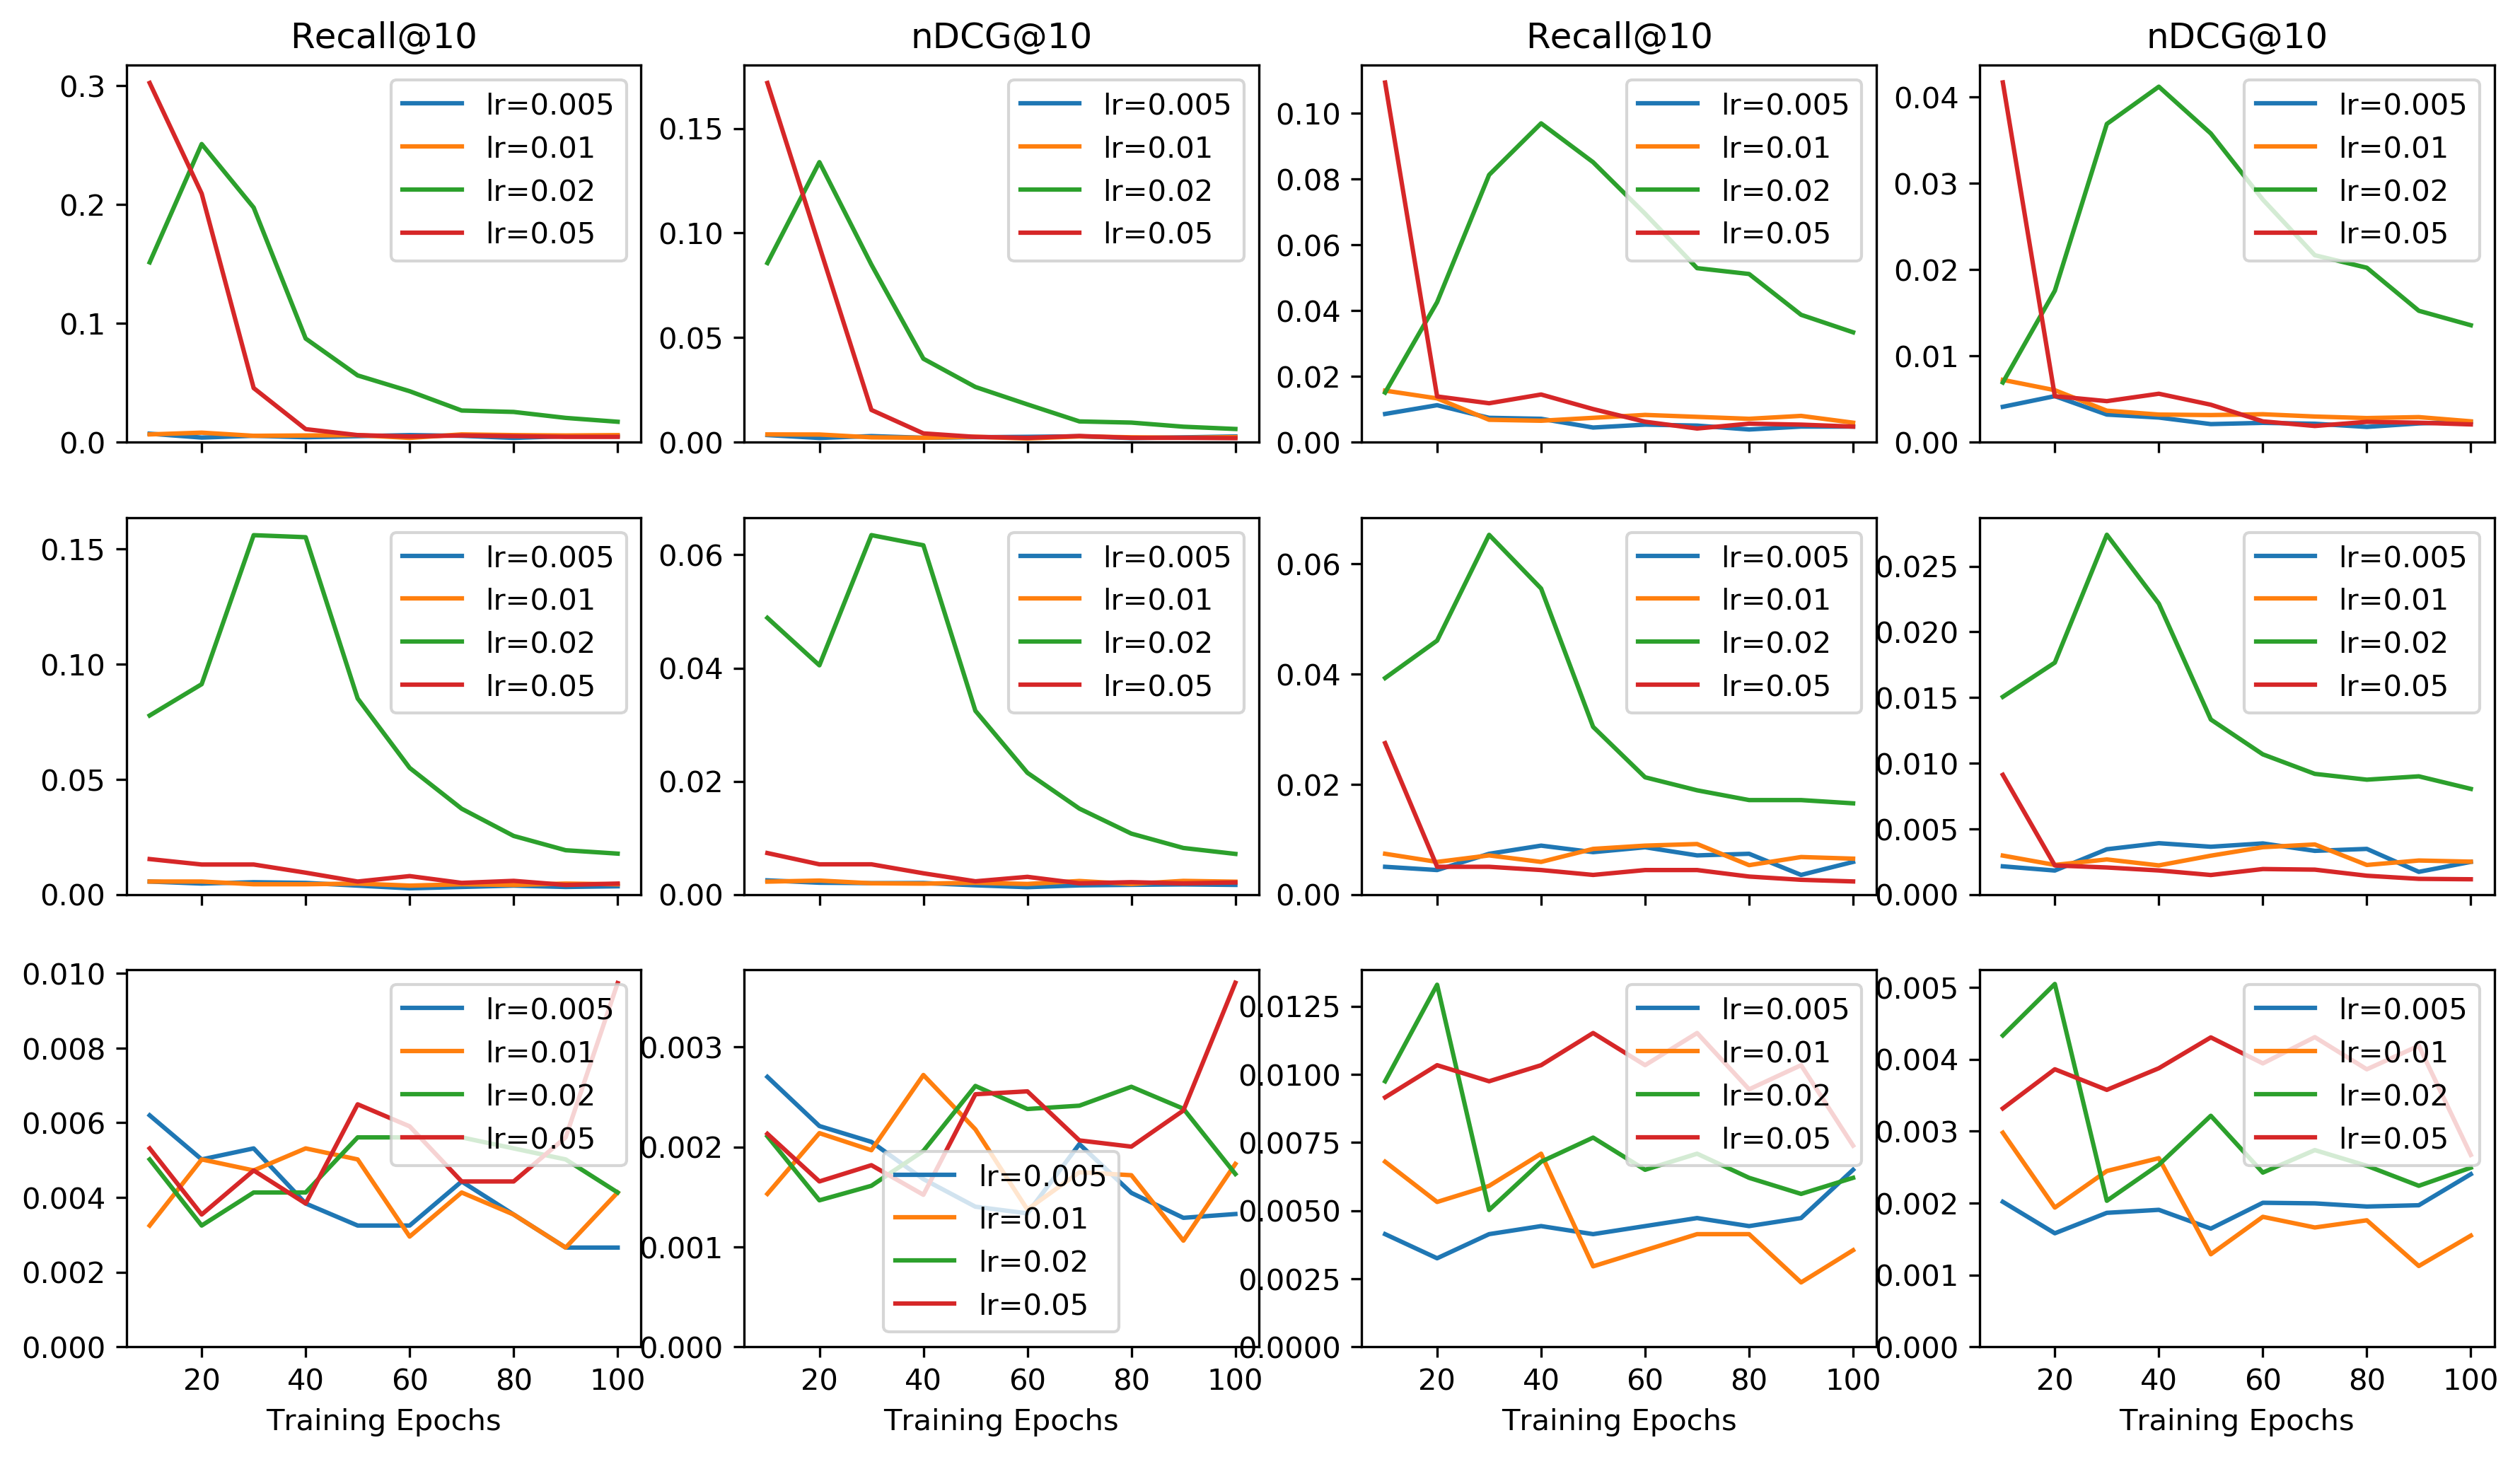

In [45]:
%matplotlib inline
plot12(frappe_tafmsingle.group_evaluations["partition"]).show()

## TAFMdual

In [42]:
frappe_tafmdual = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [43]:
for f in [64, 128, 256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "TAFMdual/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "TAFMdual_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
#                     with elapsed_timer("-- {0}s - %s" % (result_path,)):
                    frappe_tafmdual.add_evaluation(frappe_file(result_path),
                        "partition", partition=e, algorithm="TAFMdual",
                        model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


161.84235739707947s - TAFMdual/F64H128L005B256R001
160.2048852443695s - TAFMdual/F64H128L01B256R001
161.58401012420654s - TAFMdual/F64H128L02B256R001
161.45638346672058s - TAFMdual/F64H128L05B256R001
161.367689371109s - TAFMdual/F64H256L005B256R001
161.26109170913696s - TAFMdual/F64H256L01B256R001
160.696035861969s - TAFMdual/F64H256L02B256R001
160.25278759002686s - TAFMdual/F64H256L05B256R001
161.5118546485901s - TAFMdual/F128H256L005B256R001
161.5981080532074s - TAFMdual/F128H256L01B256R001
161.42370653152466s - TAFMdual/F128H256L02B256R001
161.41037249565125s - TAFMdual/F128H256L05B256R001
161.1374068260193s - TAFMdual/F128H512L005B256R001
161.20689344406128s - TAFMdual/F128H512L01B256R001
161.28422808647156s - TAFMdual/F128H512L02B256R001
161.30015349388123s - TAFMdual/F128H512L05B256R001
161.3267261981964s - TAFMdual/F256H512L005B256R001
160.447124004364s - TAFMdual/F256H512L01B256R001
160.73291611671448s - TAFMdual/F256H512L02B256R001
161.4371042251587s - TAFMdual/F256H512L05B256

In [46]:
frappe_tafmdual.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0           0.003012      0.030115        0.005475    0.020981   44.451080   
1           0.001417      0.014172        0.002577    0.006008   51.257396   
2           0.001978      0.019782        0.003597    0.007622   46.622985   
3           0.025273      0.252731        0.045951    0.134867   23.275030   
4           0.032211      0.322114        0.058566    0.174397   21.584792   
5           0.033245      0.332448        0.060445    0.176457   20.907618   
6           0.033392      0.333924        0.060713    0.176726   20.275548   
7           0.032536      0.325362        0.059157    0.168549   20.453276   
8           0.029702      0.297018        0.054003    0.155585   21.493562   
9           0.028019      0.280189        0.050943    0.149563   22.393987   
10          0.008828      0.088279        0.016051    0.030785   32.488803   
11          0.023443      0.234426        0.042623    0.138552   22.268638   
12          0.025657      0.256569        0.046649    0.154807   23.172030   
13          0.026543      0.265427        0.048259    0.143272   23.721796   
14          0.025421      0.254207        0.046220    0.105956   25.859103   
15          0.023531      0.235311        0.042784    0.097144   26.638199   
16          0.022734      0.227340        0.041335    0.107227   26.180835   
17          0.018601      0.186005        0.033819    0.080176   29.224246   
18          0.014379      0.143785        0.026143    0.058472   31.178384   
19          0.017597      0.175967        0.031994    0.079669   29.464396   
20          0.024978      0.249779        0.045414    0.132586   22.368522   
21          0.026395      0.263950        0.047991    0.130687   24.702659   
22          0.008385      0.083850        0.015245    0.033756   33.894097   
23          0.004370      0.043696        0.007945    0.018029   42.141292   
24          0.001151      0.011515        0.002094    0.004702   59.293103   
25          0.001004      0.010038        0.001825    0.004168   58.116484   
26          0.001181      0.011810        0.002147    0.005152   59.270419   
27          0.001270      0.012696        0.002308    0.005018   57.000000   
28          0.001624      0.016239        0.002952    0.006594   54.538620   
29          0.000886      0.008857        0.001610    0.004079   58.509716   
..               ...           ...             ...         ...         ...   
210         0.000620      0.006200        0.001127    0.002649   51.550388   
211         0.001270      0.012696        0.002308    0.005206   35.761905   
212         0.001004      0.010038        0.001825    0.005168   52.895254   
213         0.000797      0.007972        0.001449    0.003463   57.041878   
214         0.001535      0.015353        0.002791    0.006128   57.095944   
215         0.001742      0.017420        0.003167    0.007420   53.382707   
216         0.001565      0.015648        0.002845    0.006839   55.644949   
217         0.000945      0.009448        0.001718    0.004065   57.335299   
218         0.002008      0.020077        0.003650    0.007582   55.798387   
219         0.002716      0.027163        0.004939    0.009780   55.012918   
220         0.000590      0.005905        0.001074    0.002721   54.312057   
221         0.000945      0.009448        0.001718    0.004755   51.978788   
222         0.000650      0.006495        0.001181    0.002827   62.858557   
223         0.000679      0.006791        0.001235    0.002951   65.073661   
224         0.000650      0.006495        0.001181    0.002887   54.402256   
225         0.000679      0.006791        0.001235    0.002862   50.867257   
226         0.000709      0.007086        0.001288    0.003034   50.942623   
227         0.000974      0.009743        0.001771    0.004295   57.646688   
228         0.001181      0.011810        0.002147    0.005110   64.563559   
229         0.000886      0

### Ploting metrics

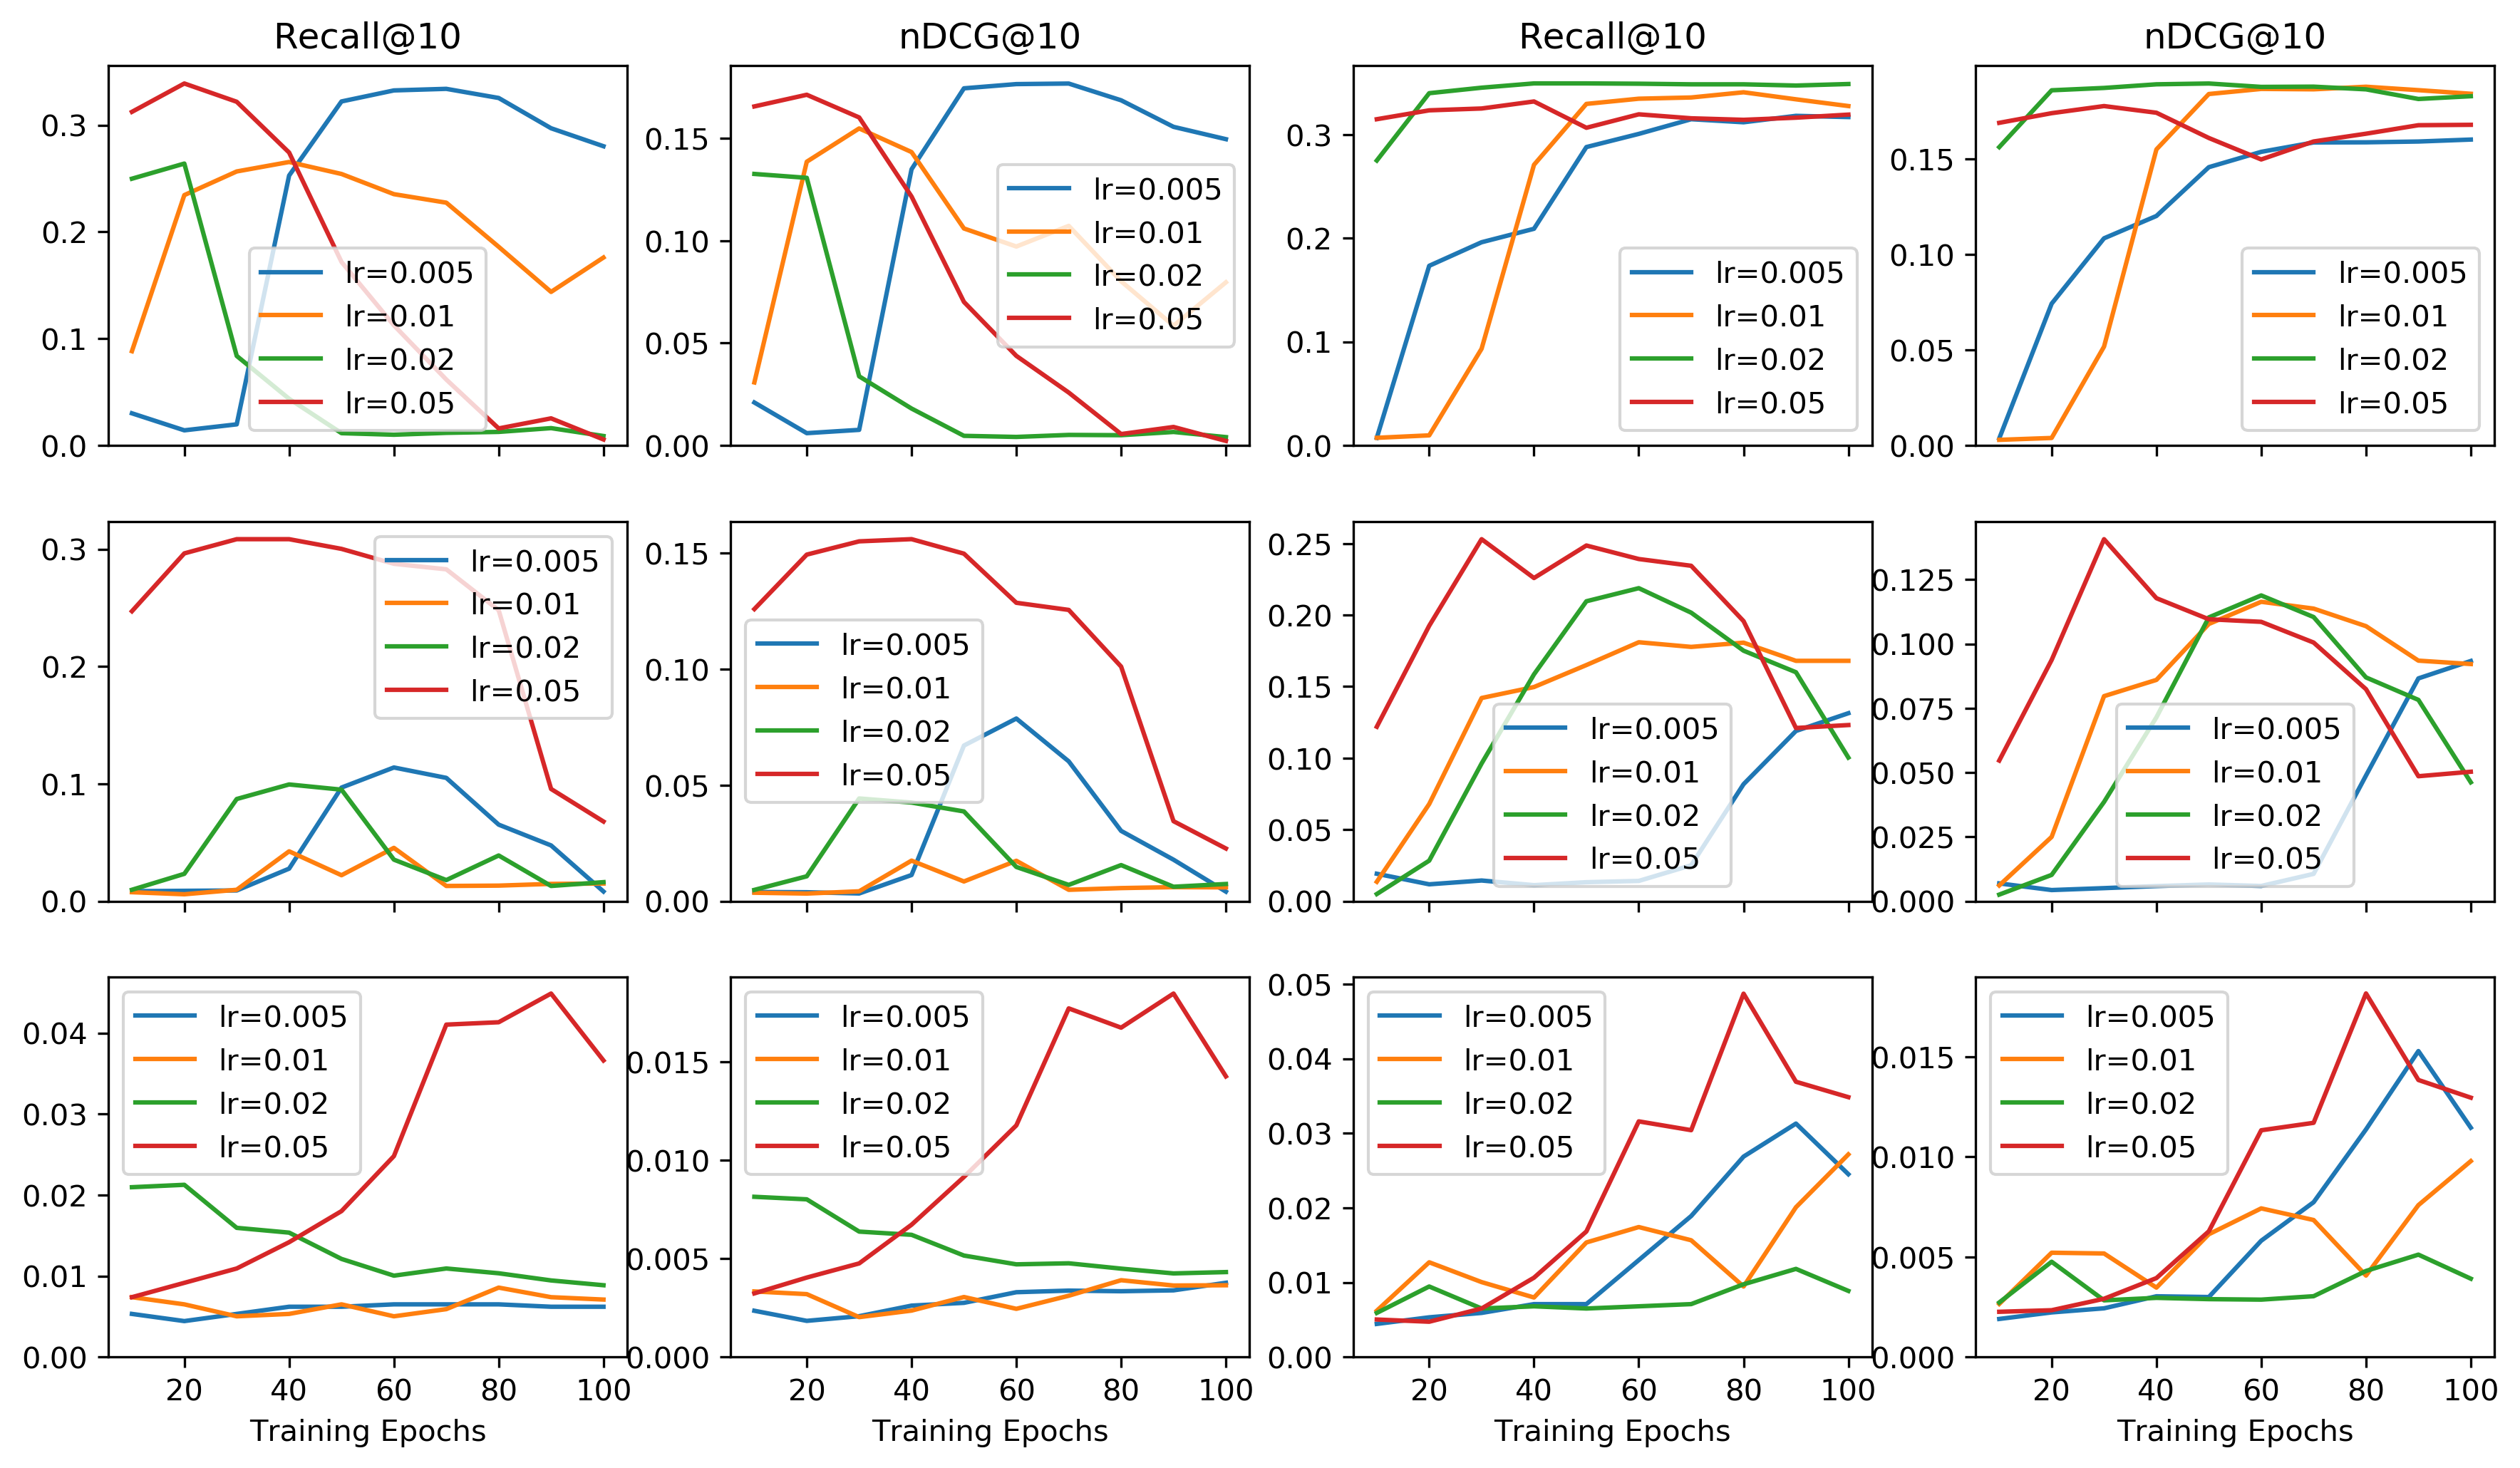

In [47]:
%matplotlib inline
plot12(frappe_tafmdual.group_evaluations["partition"]).show()

# Influence of different embedding sizes

In [ ]:
dataframe = frappe_shared_attention.group_evaluations["partition"]

In [35]:
convergence_f64 = dataframe.loc[dataframe["model_params"] == "F64H256L005B256R001"]
convergence_f64

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
10         0.003159      0.031591        0.005744    0.039889    0.022171   
11         0.012046      0.120461        0.021902    0.082860    0.068504   
12         0.021878      0.218778        0.039778    0.152405    0.137227   
13         0.024830      0.248302        0.045146    0.169372    0.151725   
14         0.023797      0.237969        0.043267    0.177958    0.162238   
15         0.026336      0.263360        0.047884    0.185691    0.166025   
16         0.027547      0.275465        0.050085    0.193556    0.173813   
17         0.028078      0.280779        0.051051    0.195827    0.176594   
18         0.025391      0.253912        0.046166    0.174555    0.154704   
19         0.025775      0.257750        0.046864    0.164428    0.139195   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
10    0.012825   0.009807   0.007313   46.547423            0.0   
11    0.059542   0.043187   0.040766   33.065336            0.0   
12    0.127215   0.101314   0.098559   26.466712            0.0   
13    0.142356   0.111686   0.109132   23.776933            0.0   
14    0.150729   0.125987   0.122860   26.251861            0.0   
15    0.151968   0.121053   0.117185   24.526584            0.0   
16    0.155388   0.123182   0.118094   22.074586            0.0   
17    0.158053   0.124975   0.119953   22.598263            0.0   
18    0.127375   0.095963   0.088532   23.340800            0.0   
19    0.118866   0.081693   0.076024   23.994180            0.0   

    event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
10                   1.0                   1.0                  0.713611   
11                   1.0                   1.0                  0.674638   
12                   1.0                   1.0                  0.565397   
13                   1.0                   1.0                  0.534101   
14                   1.0                   1.0                  0.524063   
15                   1.0                   1.0                  0.478004   
16                   1.0                   1.0                  0.465604   
17                   1.0                   1.0                  0.456156   
18                   1.0                   1.0                  0.446413   
19                   1.0                   1.0                  0.441984   

   partition algorithm         model_params  
10        10  SAFMsatt  F64H256L005B256R001  
11        20  SAFMsatt  F64H256L005B256R001  
12        30  SAFMsatt  F64H256L005B256R001  
13        40  SAFMsatt  F64H256L005B256R001  
14        50  SAFMsatt  F64H256L005B256R001  
15        60  SAFMsatt  F64H256L005B256R001  
16        70  SAFMsatt  F64H256L005B256R001  
17        80  SAFMsatt  F64H256L005B256R001  
18        90  SAFMsatt  F64H256L005B256R001  
19       100  SAFMsatt  F64H256L005B256R001

In [36]:
convergence_f128 = dataframe.loc[dataframe["model_params"] == "F128H256L05B256R001"]
convergence_f128

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
80         0.000945      0.009448        0.001718    0.019698    0.006645   
81         0.003248      0.032477        0.005905    0.042455    0.023930   
82         0.008208      0.082079        0.014923    0.069159    0.049295   
83         0.012341      0.123413        0.022439    0.093566    0.071606   
84         0.014556      0.145557        0.026465    0.112931    0.088168   
85         0.015235      0.152347        0.027699    0.118355    0.091635   
86         0.016091      0.160909        0.029256    0.126047    0.096890   
87         0.016209      0.162090        0.029471    0.129515    0.098513   
88         0.016150      0.161500        0.029364    0.130824    0.098570   
89         0.015796      0.157957        0.028719    0.131216    0.098461   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
80    0.003547   0.002595   0.001804   56.808067            0.0   
81    0.013282   0.010616   0.007709   45.145877            0.0   
82    0.035613   0.025333   0.021606   38.962437            0.0   
83    0.057158   0.041105   0.037160   35.724404            0.0   
84    0.073282   0.055362   0.051340   34.089128            0.0   
85    0.075267   0.056416   0.051953   34.452507            0.0   
86    0.079247   0.059352   0.054576   33.447887            0.0   
87    0.079567   0.059845   0.054696   33.137341            0.0   
88    0.078735   0.059235   0.053841   32.333879            0.0   
89    0.076855   0.058417   0.052506   32.165405            0.0   

    event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
80                   1.0                   1.0                  0.787718   
81                   1.0                   1.0                  0.720697   
82                   1.0                   1.0                  0.646295   
83                   1.0                   1.0                  0.578978   
84                   1.0                   1.0                  0.532920   
85                   1.0                   1.0                  0.499557   
86                   1.0                   1.0                  0.475937   
87                   1.0                   1.0                  0.464718   
88                   1.0                   1.0                  0.458813   
89                   1.0                   1.0                  0.453794   

   partition algorithm         model_params  
80        10  SAFMsatt  F128H256L05B256R001  
81        20  SAFMsatt  F128H256L05B256R001  
82        30  SAFMsatt  F128H256L05B256R001  
83        40  SAFMsatt  F128H256L05B256R001  
84        50  SAFMsatt  F128H256L05B256R001  
85        60  SAFMsatt  F128H256L05B256R001  
86        70  SAFMsatt  F128H256L05B256R001  
87        80  SAFMsatt  F128H256L05B256R001  
88        90  SAFMsatt  F128H256L05B256R001  
89       100  SAFMsatt  F128H256L05B256R001

In [37]:
convergence_f256 = dataframe.loc[dataframe["model_params"] == "F256H256L02B256R001"]
convergence_f256

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
110         0.001535      0.015353        0.002791    0.018793    0.011751   
111         0.001565      0.015648        0.002845    0.016300    0.011152   
112         0.001388      0.013877        0.002523    0.018453    0.009895   
113         0.001949      0.019486        0.003543    0.022508    0.010631   
114         0.003986      0.039858        0.007247    0.032785    0.019158   
115         0.005226      0.052259        0.009502    0.053566    0.039872   
116         0.006791      0.067907        0.012347    0.059608    0.043600   
117         0.008208      0.082079        0.014923    0.073760    0.051716   
118         0.009596      0.095955        0.017446    0.087758    0.061895   
119         0.010570      0.105698        0.019218    0.097524    0.067276   

     ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
110    0.006194   0.005057   0.003555   46.779310            0.0   
111    0.006135   0.004677   0.003332   45.478378            0.0   
112    0.006388   0.005063   0.004138   39.743440            0.0   
113    0.007710   0.005050   0.004281   48.881034            0.0   
114    0.014698   0.008688   0.007434   41.124242            0.0   
115    0.030075   0.026021   0.023441   36.037135            0.0   
116    0.035149   0.027899   0.025571   38.741585            0.0   
117    0.042727   0.033389   0.030983   37.933979            0.0   
118    0.050460   0.039784   0.036716   36.002283            0.0   
119    0.050365   0.038675   0.034051   33.516238            0.0   

     event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
110                   1.0                   1.0                  0.871568   
111                   1.0                   1.0                  0.890759   
112                   1.0                   1.0                  0.898730   
113                   1.0                   1.0                  0.828757   
114                   1.0                   1.0                  0.805137   
115                   1.0                   1.0                  0.777384   
116                   1.0                   1.0                  0.728078   
117                   1.0                   1.0                  0.664600   
118                   1.0                   1.0                  0.612046   
119                   1.0                   1.0                  0.563626   

    partition algorithm         model_params  
110        10  SAFMsatt  F256H256L02B256R001  
111        20  SAFMsatt  F256H256L02B256R001  
112        30  SAFMsatt  F256H256L02B256R001  
113        40  SAFMsatt  F256H256L02B256R001  
114        50  SAFMsatt  F256H256L02B256R001  
115        60  SAFMsatt  F256H256L02B256R001  
116        70  SAFMsatt  F256H256L02B256R001  
117        80  SAFMsatt  F256H256L02B256R001  
118        90  SAFMsatt  F256H256L02B256R001  
119       100  SAFMsatt  F256H256L02B256R001

## Influence of Sharing

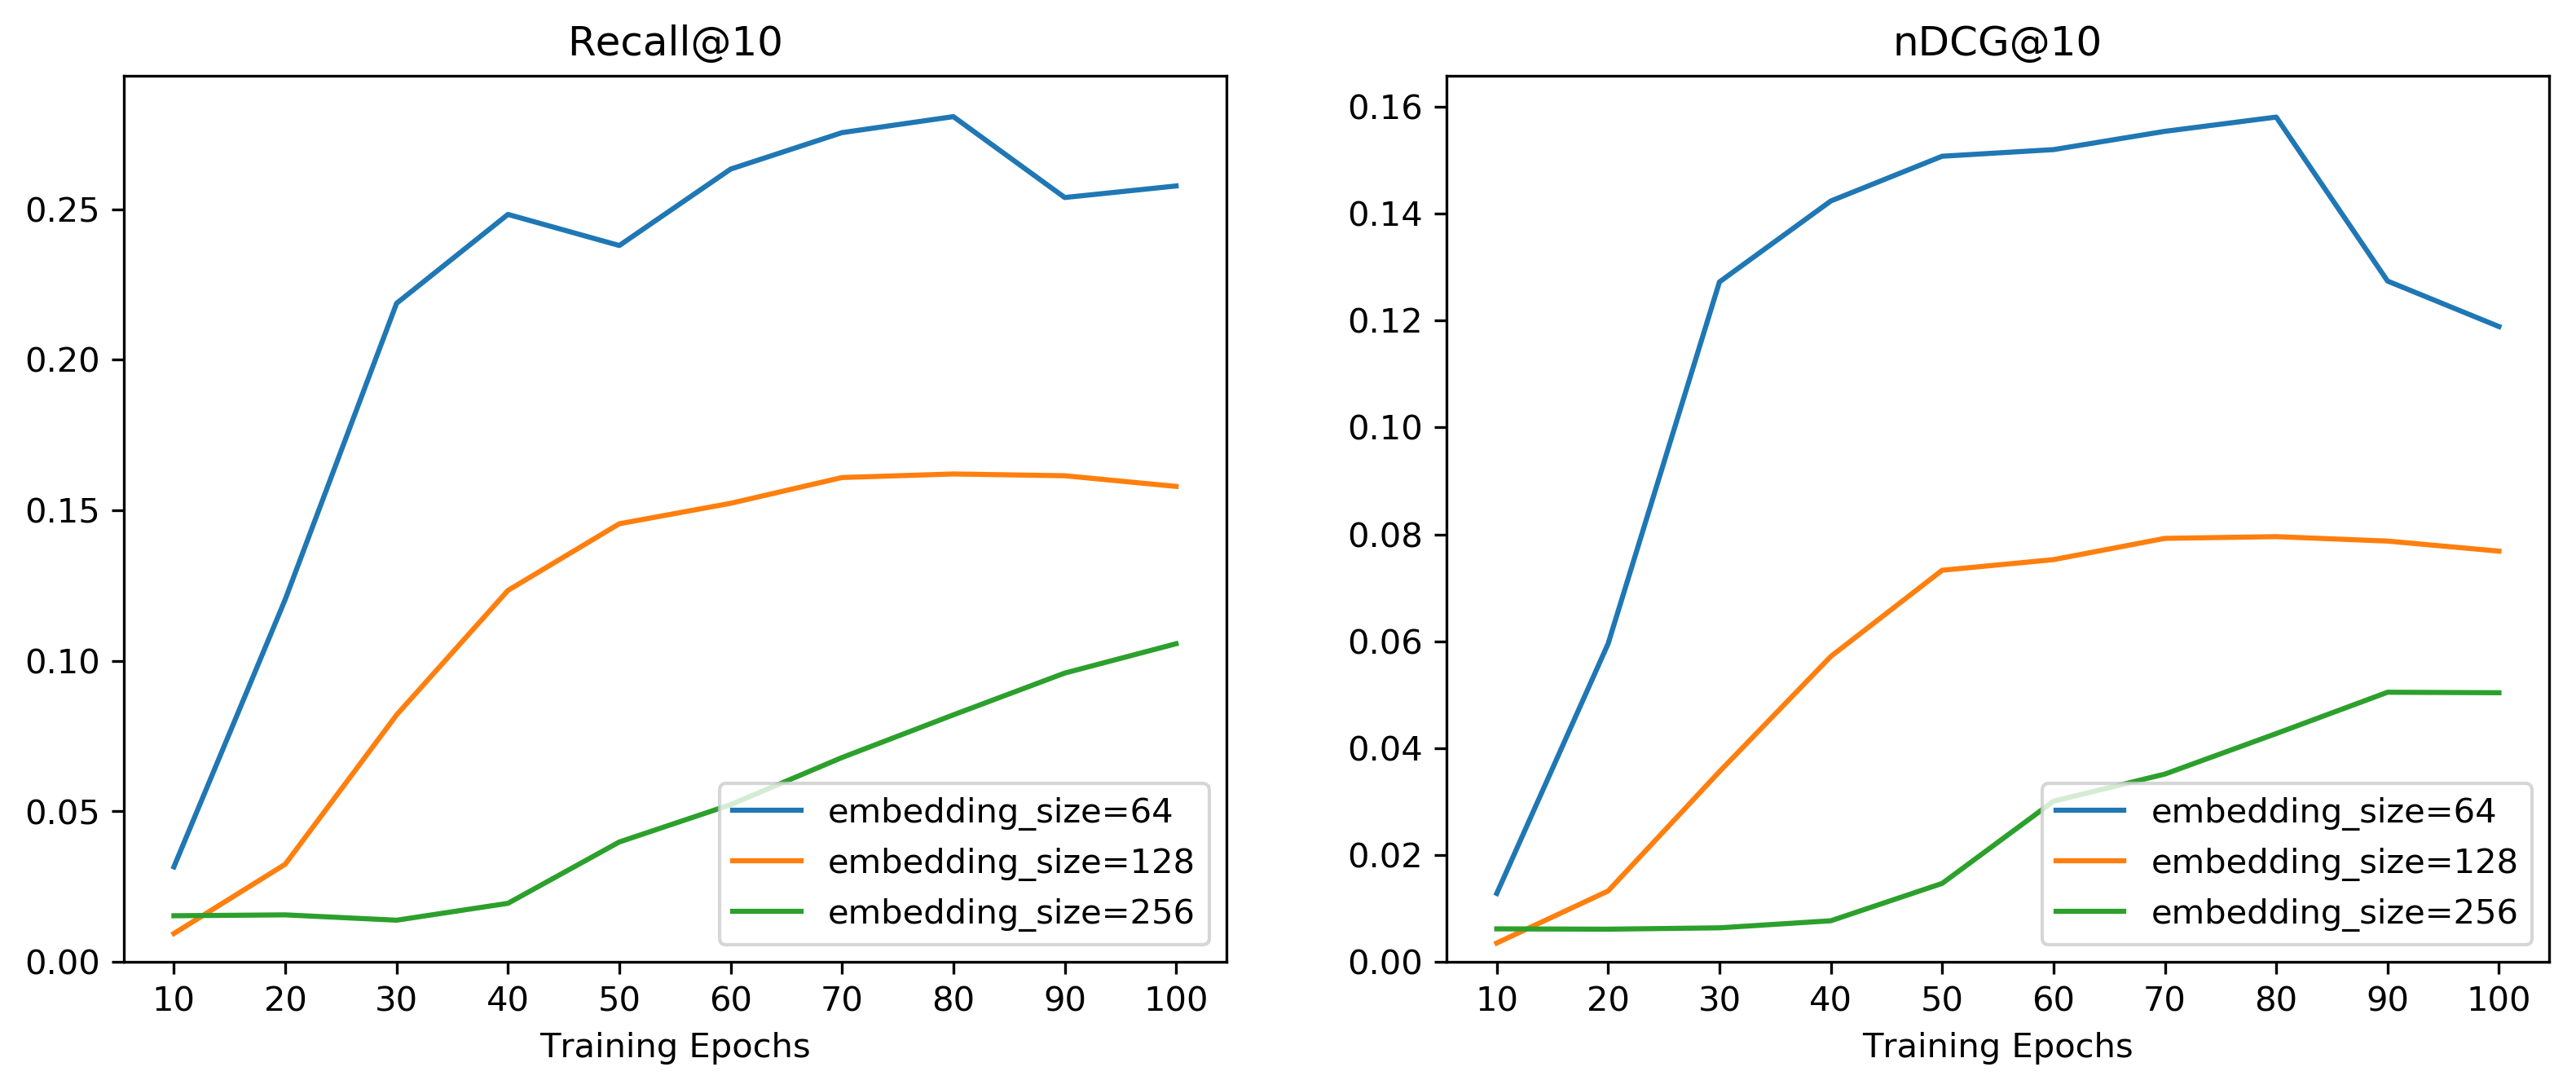

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

embedding_fig = plt.figure(figsize=[12.8, 4.8], dpi=300)
ax_recall, ax_ndcg = embedding_fig.subplots(nrows=1, ncols=2)

ax_recall.set_title("Recall@10")
ax_recall.set_xlabel("Training Epochs")
ax_recall.plot(convergence_f64["partition"], convergence_f64["recall_at_10"],
               label="embedding_size=64")
ax_recall.plot(convergence_f128["partition"], convergence_f128["recall_at_10"],
               label="embedding_size=128")
ax_recall.plot(convergence_f256["partition"], convergence_f256["recall_at_10"],
               label="embedding_size=256")
ax_recall.set_ylim(bottom=0.0)
ax_recall.legend()

ax_ndcg.set_title("nDCG@10")
ax_ndcg.set_xlabel("Training Epochs")
ax_ndcg.plot(convergence_f64["partition"], convergence_f64["ndcg_at_10"],
             label="embedding_size=64")
ax_ndcg.plot(convergence_f128["partition"], convergence_f128["ndcg_at_10"],
             label="embedding_size=128")
ax_ndcg.plot(convergence_f256["partition"], convergence_f256["ndcg_at_10"],
             label="embedding_size=256")
ax_ndcg.set_ylim(bottom=0.0)
ax_ndcg.legend()

embedding_fig.savefig("../evaluation-images/results-embedding_sizes.eps")
embedding_fig.savefig("../evaluation-images/results-embedding_sizes.jpg")
embedding_fig.show()

### Shared Attention

In [8]:
frappe_shared_attention = EvaluatePartition("../partitioned_data/frappe/partition_1/")

users: 3387, events: 856


In [12]:
import time

for f in [64, 128, 256]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMsp/shared-attention/F{0}L{1}B256R001".format(f, l)
        begin_time = time.time()
        for e in [str(e) for e in range(10, 100 + 1, 10)]:
            frappe_shared_attention.add_evaluation(
                frappe_file(os.path.join(result_dir, "SAFMsatt_F{0}H256L{1}B256E{2}R001.tsv".format(f, l, e))),
                "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H256L{1}B256R001".format(f, l))
        LOGGER.critical("[%fs] Evaluated %s", time.time() - begin_time, result_dir)

[331.607797s] Evaluated SAFMsp/shared-attention/F64L005B256R001
[317.222225s] Evaluated SAFMsp/shared-attention/F64L01B256R001
[317.682797s] Evaluated SAFMsp/shared-attention/F64L02B256R001
[314.523597s] Evaluated SAFMsp/shared-attention/F64L05B256R001
[321.701800s] Evaluated SAFMsp/shared-attention/F128L005B256R001
[317.260084s] Evaluated SAFMsp/shared-attention/F128L01B256R001
[313.563052s] Evaluated SAFMsp/shared-attention/F128L02B256R001
[320.447717s] Evaluated SAFMsp/shared-attention/F128L05B256R001
[318.075285s] Evaluated SAFMsp/shared-attention/F256L005B256R001
[314.478319s] Evaluated SAFMsp/shared-attention/F256L01B256R001
[312.518872s] Evaluated SAFMsp/shared-attention/F256L02B256R001
[316.030760s] Evaluated SAFMsp/shared-attention/F256L05B256R001


In [13]:
frappe_shared_attention.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0           0.003159      0.031591        0.005744    0.039889    0.022171   
1           0.012046      0.120461        0.021902    0.082860    0.068504   
2           0.021878      0.218778        0.039778    0.152405    0.137227   
3           0.024830      0.248302        0.045146    0.169372    0.151725   
4           0.023797      0.237969        0.043267    0.177958    0.162238   
5           0.026336      0.263360        0.047884    0.185691    0.166025   
6           0.027547      0.275465        0.050085    0.193556    0.173813   
7           0.028078      0.280779        0.051051    0.195827    0.176594   
8           0.025391      0.253912        0.046166    0.174555    0.154704   
9           0.025775      0.257750        0.046864    0.164428    0.139195   
10          0.003159      0.031591        0.005744    0.039889    0.022171   
11          0.012046      0.120461        0.021902    0.082860    0.068504   
12          0.021878      0.218778        0.039778    0.152405    0.137227   
13          0.024830      0.248302        0.045146    0.169372    0.151725   
14          0.023797      0.237969        0.043267    0.177958    0.162238   
15          0.026336      0.263360        0.047884    0.185691    0.166025   
16          0.027547      0.275465        0.050085    0.193556    0.173813   
17          0.028078      0.280779        0.051051    0.195827    0.176594   
18          0.025391      0.253912        0.046166    0.174555    0.154704   
19          0.025775      0.257750        0.046864    0.164428    0.139195   
20          0.004311      0.043106        0.007837    0.062832    0.029980   
21          0.007735      0.077355        0.014064    0.068621    0.045298   
22          0.006673      0.066726        0.012132    0.067435    0.041619   
23          0.005521      0.055211        0.010038    0.064002    0.034047   
24          0.004960      0.049601        0.009018    0.060886    0.033571   
25          0.002332      0.023324        0.004241    0.047876    0.020368   
26          0.001565      0.015648        0.002845    0.043215    0.012705   
27          0.001771      0.017715        0.003221    0.036663    0.013024   
28          0.000974      0.009743        0.001771    0.036368    0.010025   
29          0.000915      0.009153        0.001664    0.037848    0.009460   
..               ...           ...             ...         ...         ...   
100         0.000561      0.005610        0.001020    0.008472    0.004757   
101         0.000472      0.004724        0.000859    0.006393    0.003207   
102         0.000443      0.004429        0.000805    0.006755    0.003570   
103         0.000354      0.003543        0.000644    0.006690    0.003629   
104         0.000325      0.003248        0.000590    0.003988    0.001949   
105         0.000354      0.003543        0.000644    0.004266    0.002353   
106         0.000413      0.004133        0.000752    0.004400    0.002595   
107         0.000384      0.003838        0.000698    0.004458    0.002683   
108         0.000502      0.005019        0.000913    0.004850    0.003204   
109         0.000295      0.002952        0.000537    0.004246    0.002549   
110         0.001535      0.015353        0.002791    0.018793    0.011751   
111         0.001565      0.015648        0.002845    0.016300    0.011152   
112         0.001388      0.013877        0.002523    0.018453    0.009895   
113         0.001949      0.019486        0.003543    0.022508    0.010631   
114         0.003986      0.039858        0.007247    0.032785    0.019158   
115         0.005226      0.052259        0.009502    0.053566    0.039872   
116         0.006791      0.067907        0.012347    0.059608    0.043600   
117         0.008208      0.082079        0.014923    0.073760    0.051716   
118         0.009596      0.095955        0.017446    0.087758    0.061895   
119         0.010570      0

In [23]:
mixed_evaluations = frappe_shared_attention.group_evaluations["partition"]
mixed_evaluations

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0           0.003159      0.031591        0.005744    0.039889    0.022171   
1           0.012046      0.120461        0.021902    0.082860    0.068504   
2           0.021878      0.218778        0.039778    0.152405    0.137227   
3           0.024830      0.248302        0.045146    0.169372    0.151725   
4           0.023797      0.237969        0.043267    0.177958    0.162238   
5           0.026336      0.263360        0.047884    0.185691    0.166025   
6           0.027547      0.275465        0.050085    0.193556    0.173813   
7           0.028078      0.280779        0.051051    0.195827    0.176594   
8           0.025391      0.253912        0.046166    0.174555    0.154704   
9           0.025775      0.257750        0.046864    0.164428    0.139195   
10          0.003159      0.031591        0.005744    0.039889    0.022171   
11          0.012046      0.120461        0.021902    0.082860    0.068504   
12          0.021878      0.218778        0.039778    0.152405    0.137227   
13          0.024830      0.248302        0.045146    0.169372    0.151725   
14          0.023797      0.237969        0.043267    0.177958    0.162238   
15          0.026336      0.263360        0.047884    0.185691    0.166025   
16          0.027547      0.275465        0.050085    0.193556    0.173813   
17          0.028078      0.280779        0.051051    0.195827    0.176594   
18          0.025391      0.253912        0.046166    0.174555    0.154704   
19          0.025775      0.257750        0.046864    0.164428    0.139195   
20          0.004311      0.043106        0.007837    0.062832    0.029980   
21          0.007735      0.077355        0.014064    0.068621    0.045298   
22          0.006673      0.066726        0.012132    0.067435    0.041619   
23          0.005521      0.055211        0.010038    0.064002    0.034047   
24          0.004960      0.049601        0.009018    0.060886    0.033571   
25          0.002332      0.023324        0.004241    0.047876    0.020368   
26          0.001565      0.015648        0.002845    0.043215    0.012705   
27          0.001771      0.017715        0.003221    0.036663    0.013024   
28          0.000974      0.009743        0.001771    0.036368    0.010025   
29          0.000915      0.009153        0.001664    0.037848    0.009460   
..               ...           ...             ...         ...         ...   
220         0.001358      0.013581        0.002469    0.023041    0.011383   
221         0.000650      0.006495        0.001181    0.019539    0.006171   
222         0.001919      0.019191        0.003489    0.028741    0.012666   
223         0.000384      0.003838        0.000698    0.007003    0.003426   
224         0.000384      0.003838        0.000698    0.004538    0.002264   
225         0.000443      0.004429        0.000805    0.004109    0.002424   
226         0.000443      0.004429        0.000805    0.004054    0.002189   
227         0.000472      0.004724        0.000859    0.004017    0.002303   
228         0.000266      0.002657        0.000483    0.004085    0.002255   
229         0.000295      0.002952        0.000537    0.003985    0.001908   
230         0.000590      0.005905        0.001074    0.023589    0.007795   
231         0.000177      0.001771        0.000322    0.003805    0.001791   
232         0.000295      0.002952        0.000537    0.004036    0.002223   
233         0.000266      0.002657        0.000483    0.003873    0.001834   
234         0.000207      0.002067        0.000376    0.003734    0.001666   
235         0.000295      0.002952        0.000537    0.004078    0.002212   
236         0.000413      0.004133        0.000752    0.004482    0.002600   
237         0.000295      0.002952        0.000537    0.004360    0.002251   
238         0.000325      0.003248        0.000590    0.004872    0.002433   
239         0.000413      0

In [24]:
frappe_shared_attention.group_evaluations["partition"] = \
    mixed_evaluations.loc[mixed_evaluations["algorithm"] == "SAFMsatt", :]
frappe_shared_attention.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0           0.003159      0.031591        0.005744    0.039889    0.022171   
1           0.012046      0.120461        0.021902    0.082860    0.068504   
2           0.021878      0.218778        0.039778    0.152405    0.137227   
3           0.024830      0.248302        0.045146    0.169372    0.151725   
4           0.023797      0.237969        0.043267    0.177958    0.162238   
5           0.026336      0.263360        0.047884    0.185691    0.166025   
6           0.027547      0.275465        0.050085    0.193556    0.173813   
7           0.028078      0.280779        0.051051    0.195827    0.176594   
8           0.025391      0.253912        0.046166    0.174555    0.154704   
9           0.025775      0.257750        0.046864    0.164428    0.139195   
10          0.003159      0.031591        0.005744    0.039889    0.022171   
11          0.012046      0.120461        0.021902    0.082860    0.068504   
12          0.021878      0.218778        0.039778    0.152405    0.137227   
13          0.024830      0.248302        0.045146    0.169372    0.151725   
14          0.023797      0.237969        0.043267    0.177958    0.162238   
15          0.026336      0.263360        0.047884    0.185691    0.166025   
16          0.027547      0.275465        0.050085    0.193556    0.173813   
17          0.028078      0.280779        0.051051    0.195827    0.176594   
18          0.025391      0.253912        0.046166    0.174555    0.154704   
19          0.025775      0.257750        0.046864    0.164428    0.139195   
20          0.004311      0.043106        0.007837    0.062832    0.029980   
21          0.007735      0.077355        0.014064    0.068621    0.045298   
22          0.006673      0.066726        0.012132    0.067435    0.041619   
23          0.005521      0.055211        0.010038    0.064002    0.034047   
24          0.004960      0.049601        0.009018    0.060886    0.033571   
25          0.002332      0.023324        0.004241    0.047876    0.020368   
26          0.001565      0.015648        0.002845    0.043215    0.012705   
27          0.001771      0.017715        0.003221    0.036663    0.013024   
28          0.000974      0.009743        0.001771    0.036368    0.010025   
29          0.000915      0.009153        0.001664    0.037848    0.009460   
..               ...           ...             ...         ...         ...   
100         0.000561      0.005610        0.001020    0.008472    0.004757   
101         0.000472      0.004724        0.000859    0.006393    0.003207   
102         0.000443      0.004429        0.000805    0.006755    0.003570   
103         0.000354      0.003543        0.000644    0.006690    0.003629   
104         0.000325      0.003248        0.000590    0.003988    0.001949   
105         0.000354      0.003543        0.000644    0.004266    0.002353   
106         0.000413      0.004133        0.000752    0.004400    0.002595   
107         0.000384      0.003838        0.000698    0.004458    0.002683   
108         0.000502      0.005019        0.000913    0.004850    0.003204   
109         0.000295      0.002952        0.000537    0.004246    0.002549   
110         0.001535      0.015353        0.002791    0.018793    0.011751   
111         0.001565      0.015648        0.002845    0.016300    0.011152   
112         0.001388      0.013877        0.002523    0.018453    0.009895   
113         0.001949      0.019486        0.003543    0.022508    0.010631   
114         0.003986      0.039858        0.007247    0.032785    0.019158   
115         0.005226      0.052259        0.009502    0.053566    0.039872   
116         0.006791      0.067907        0.012347    0.059608    0.043600   
117         0.008208      0.082079        0.014923    0.073760    0.051716   
118         0.009596      0.095955        0.017446    0.087758    0.061895   
119         0.010570      0

In [26]:
frappe_shared_attention.group_evaluations["partition"].drop(list(range(10)), inplace=True)
frappe_shared_attention.group_evaluations["partition"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
10          0.003159      0.031591        0.005744    0.039889    0.022171   
11          0.012046      0.120461        0.021902    0.082860    0.068504   
12          0.021878      0.218778        0.039778    0.152405    0.137227   
13          0.024830      0.248302        0.045146    0.169372    0.151725   
14          0.023797      0.237969        0.043267    0.177958    0.162238   
15          0.026336      0.263360        0.047884    0.185691    0.166025   
16          0.027547      0.275465        0.050085    0.193556    0.173813   
17          0.028078      0.280779        0.051051    0.195827    0.176594   
18          0.025391      0.253912        0.046166    0.174555    0.154704   
19          0.025775      0.257750        0.046864    0.164428    0.139195   
20          0.004311      0.043106        0.007837    0.062832    0.029980   
21          0.007735      0.077355        0.014064    0.068621    0.045298   
22          0.006673      0.066726        0.012132    0.067435    0.041619   
23          0.005521      0.055211        0.010038    0.064002    0.034047   
24          0.004960      0.049601        0.009018    0.060886    0.033571   
25          0.002332      0.023324        0.004241    0.047876    0.020368   
26          0.001565      0.015648        0.002845    0.043215    0.012705   
27          0.001771      0.017715        0.003221    0.036663    0.013024   
28          0.000974      0.009743        0.001771    0.036368    0.010025   
29          0.000915      0.009153        0.001664    0.037848    0.009460   
30          0.005373      0.053735        0.009770    0.062910    0.036401   
31          0.004104      0.041039        0.007462    0.035881    0.027263   
32          0.003897      0.038973        0.007086    0.030074    0.024124   
33          0.004517      0.045173        0.008213    0.034782    0.029539   
34          0.007027      0.070269        0.012776    0.057355    0.043863   
35          0.008001      0.080012        0.014548    0.077281    0.056378   
36          0.008739      0.087393        0.015890    0.096628    0.062512   
37          0.008651      0.086507        0.015729    0.093829    0.061728   
38          0.009389      0.093888        0.017071    0.100939    0.064334   
39          0.009448      0.094479        0.017178    0.099333    0.063878   
..               ...           ...             ...         ...         ...   
100         0.000561      0.005610        0.001020    0.008472    0.004757   
101         0.000472      0.004724        0.000859    0.006393    0.003207   
102         0.000443      0.004429        0.000805    0.006755    0.003570   
103         0.000354      0.003543        0.000644    0.006690    0.003629   
104         0.000325      0.003248        0.000590    0.003988    0.001949   
105         0.000354      0.003543        0.000644    0.004266    0.002353   
106         0.000413      0.004133        0.000752    0.004400    0.002595   
107         0.000384      0.003838        0.000698    0.004458    0.002683   
108         0.000502      0.005019        0.000913    0.004850    0.003204   
109         0.000295      0.002952        0.000537    0.004246    0.002549   
110         0.001535      0.015353        0.002791    0.018793    0.011751   
111         0.001565      0.015648        0.002845    0.016300    0.011152   
112         0.001388      0.013877        0.002523    0.018453    0.009895   
113         0.001949      0.019486        0.003543    0.022508    0.010631   
114         0.003986      0.039858        0.007247    0.032785    0.019158   
115         0.005226      0.052259        0.009502    0.053566    0.039872   
116         0.006791      0.067907        0.012347    0.059608    0.043600   
117         0.008208      0.082079        0.014923    0.073760    0.051716   
118         0.009596      0.095955        0.017446    0.087758    0.061895   
119         0.010570      0

#### Ploting metrics

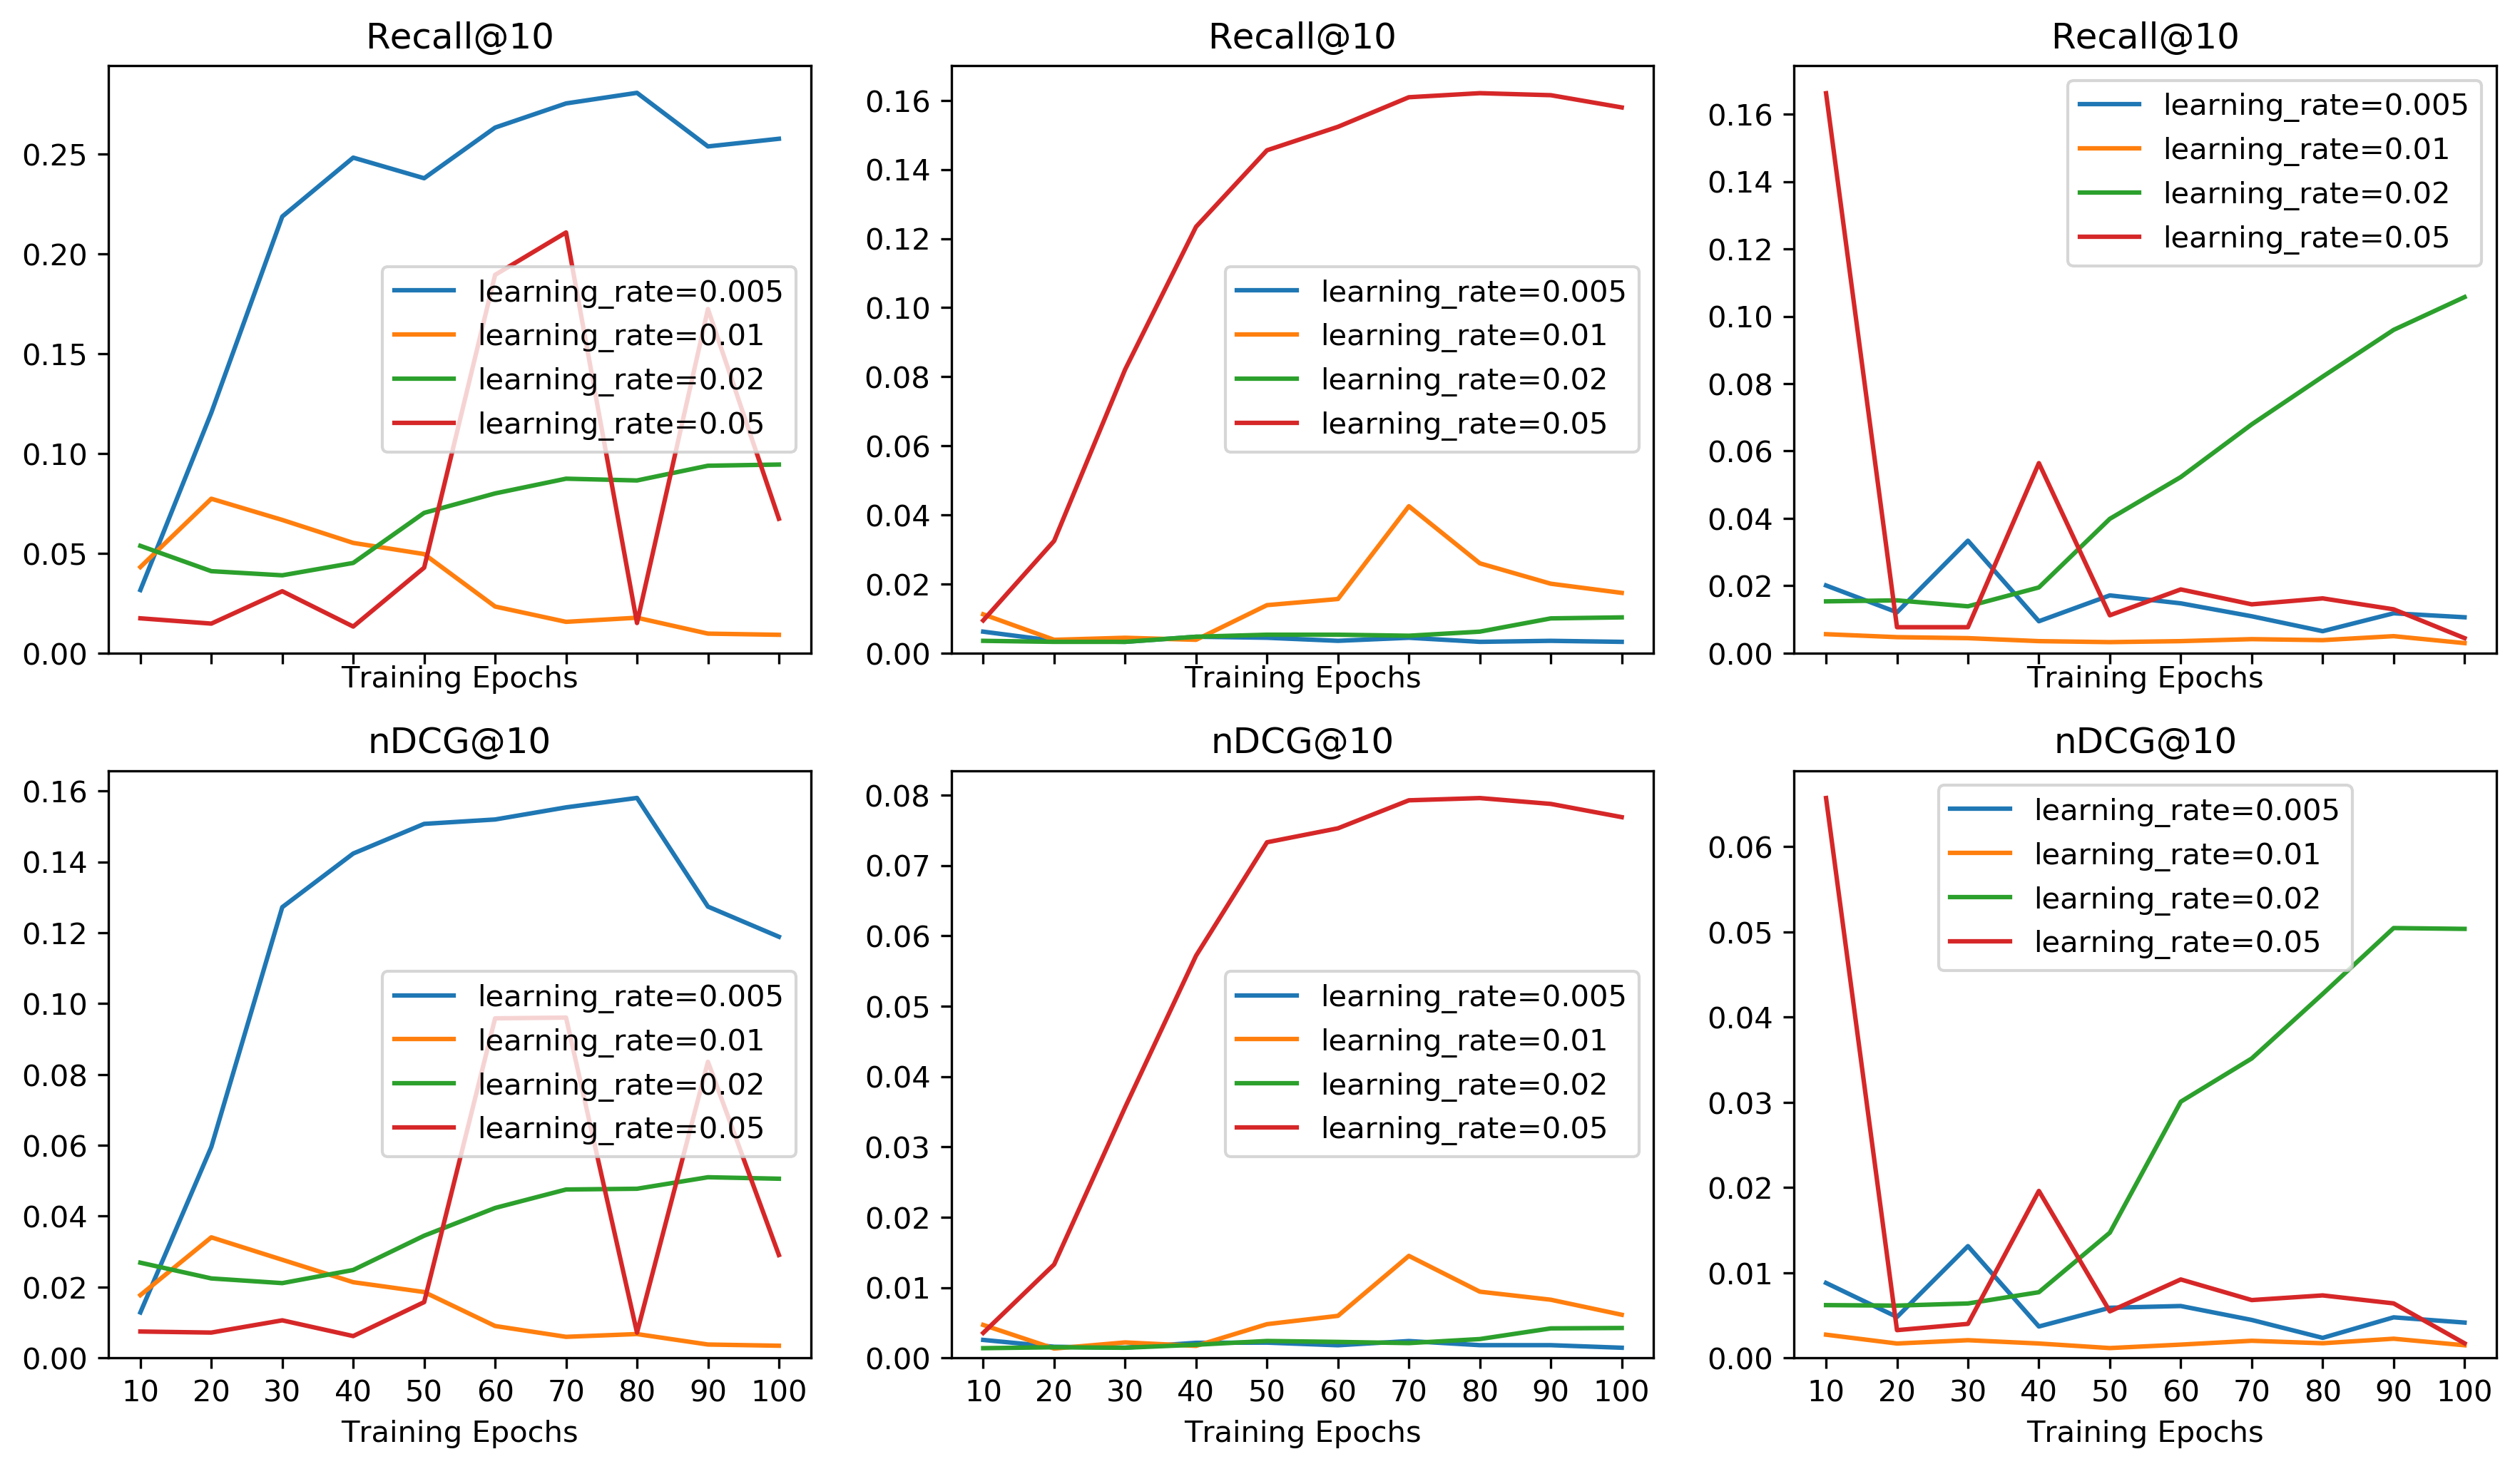

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_shared_attention.group_evaluations["partition"]
frappe_shared_attention_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = frappe_shared_attention_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
frappe_shared_attention_fig.show()

### Shared FeedForward

In [14]:
frappe_shared_feedforward = EvaluatePartition("../partitioned_data/frappe/partition_1/")

users: 3387, events: 856


In [15]:
import time

for f in [64, 128, 256]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMsp/shared-feedforward/F{0}L{1}B256R001".format(f, l)
        begin_time = time.time()
        for e in [str(e) for e in range(10, 100 + 1, 10)]:
            frappe_shared_feedforward.add_evaluation(
                frappe_file(os.path.join(result_dir, "SAFMsf_F{0}H256L{1}B256E{2}R001.tsv".format(f, l, e))),
                "partition", partition=e, algorithm="SAFMsf", model_params="F{0}H256L{1}B256R001".format(f, l))
        LOGGER.critical("[%fs] Evaluated %s", time.time() - begin_time, result_dir)

[312.767706s] Evaluated SAFMsp/shared-feedforward/F64L005B256R001
[318.978909s] Evaluated SAFMsp/shared-feedforward/F64L01B256R001
[309.381208s] Evaluated SAFMsp/shared-feedforward/F64L02B256R001
[309.931755s] Evaluated SAFMsp/shared-feedforward/F64L05B256R001
[310.154457s] Evaluated SAFMsp/shared-feedforward/F128L005B256R001
[310.373095s] Evaluated SAFMsp/shared-feedforward/F128L01B256R001
[317.597084s] Evaluated SAFMsp/shared-feedforward/F128L02B256R001
[313.607626s] Evaluated SAFMsp/shared-feedforward/F128L05B256R001
[309.857438s] Evaluated SAFMsp/shared-feedforward/F256L005B256R001
[309.067229s] Evaluated SAFMsp/shared-feedforward/F256L01B256R001
[307.898757s] Evaluated SAFMsp/shared-feedforward/F256L02B256R001
[310.228130s] Evaluated SAFMsp/shared-feedforward/F256L05B256R001


In [21]:
frappe_shared_feedforward.group_evaluations["partition"] = \
    frappe_shared_attention.group_evaluations["partition"].loc[
        frappe_shared_attention.group_evaluations["partition"]["algorithm"] == "SAFMsf", :]

#### Ploting metrics

In [22]:
frappe_shared_feedforward.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
130         0.008090      0.080898        0.014709    0.060593    0.040054   
131         0.007795      0.077945        0.014172    0.076128    0.047519   
132         0.003986      0.039858        0.007247    0.065764    0.035826   
133         0.004665      0.046649        0.008482    0.074550    0.041782   
134         0.005255      0.052554        0.009555    0.082972    0.042502   
135         0.005787      0.057868        0.010522    0.065694    0.035414   
136         0.002096      0.020963        0.003811    0.049957    0.021251   
137         0.001890      0.018896        0.003436    0.042041    0.017073   
138         0.001712      0.017124        0.003114    0.038940    0.014766   
139         0.001565      0.015648        0.002845    0.029138    0.010746   
140         0.007883      0.078831        0.014333    0.063930    0.043883   
141         0.009802      0.098022        0.017822    0.075447    0.054785   
142         0.013552      0.135518        0.024640    0.099791    0.079634   
143         0.014556      0.145557        0.026465    0.110691    0.089210   
144         0.011898      0.118984        0.021634    0.095273    0.069795   
145         0.008296      0.082964        0.015084    0.088552    0.056889   
146         0.003513      0.035134        0.006388    0.077412    0.037769   
147         0.004783      0.047830        0.008696    0.078814    0.041613   
148         0.003218      0.032182        0.005851    0.068594    0.031810   
149         0.003484      0.034839        0.006334    0.064461    0.027579   
150         0.000945      0.009448        0.001718    0.030853    0.009013   
151         0.000325      0.003248        0.000590    0.035166    0.004451   
152         0.000472      0.004724        0.000859    0.030590    0.003948   
153         0.000472      0.004724        0.000859    0.025706    0.004731   
154         0.000443      0.004429        0.000805    0.021211    0.004579   
155         0.000413      0.004133        0.000752    0.016024    0.003856   
156         0.000413      0.004133        0.000752    0.013910    0.003478   
157         0.000413      0.004133        0.000752    0.016357    0.003404   
158         0.000413      0.004133        0.000752    0.018767    0.003782   
159         0.000472      0.004724        0.000859    0.018866    0.003500   
..               ...           ...             ...         ...         ...   
220         0.001358      0.013581        0.002469    0.023041    0.011383   
221         0.000650      0.006495        0.001181    0.019539    0.006171   
222         0.001919      0.019191        0.003489    0.028741    0.012666   
223         0.000384      0.003838        0.000698    0.007003    0.003426   
224         0.000384      0.003838        0.000698    0.004538    0.002264   
225         0.000443      0.004429        0.000805    0.004109    0.002424   
226         0.000443      0.004429        0.000805    0.004054    0.002189   
227         0.000472      0.004724        0.000859    0.004017    0.002303   
228         0.000266      0.002657        0.000483    0.004085    0.002255   
229         0.000295      0.002952        0.000537    0.003985    0.001908   
230         0.000590      0.005905        0.001074    0.023589    0.007795   
231         0.000177      0.001771        0.000322    0.003805    0.001791   
232         0.000295      0.002952        0.000537    0.004036    0.002223   
233         0.000266      0.002657        0.000483    0.003873    0.001834   
234         0.000207      0.002067        0.000376    0.003734    0.001666   
235         0.000295      0.002952        0.000537    0.004078    0.002212   
236         0.000413      0.004133        0.000752    0.004482    0.002600   
237         0.000295      0.002952        0.000537    0.004360    0.002251   
238         0.000325      0.003248        0.000590    0.004872    0.002433   
239         0.000413      0

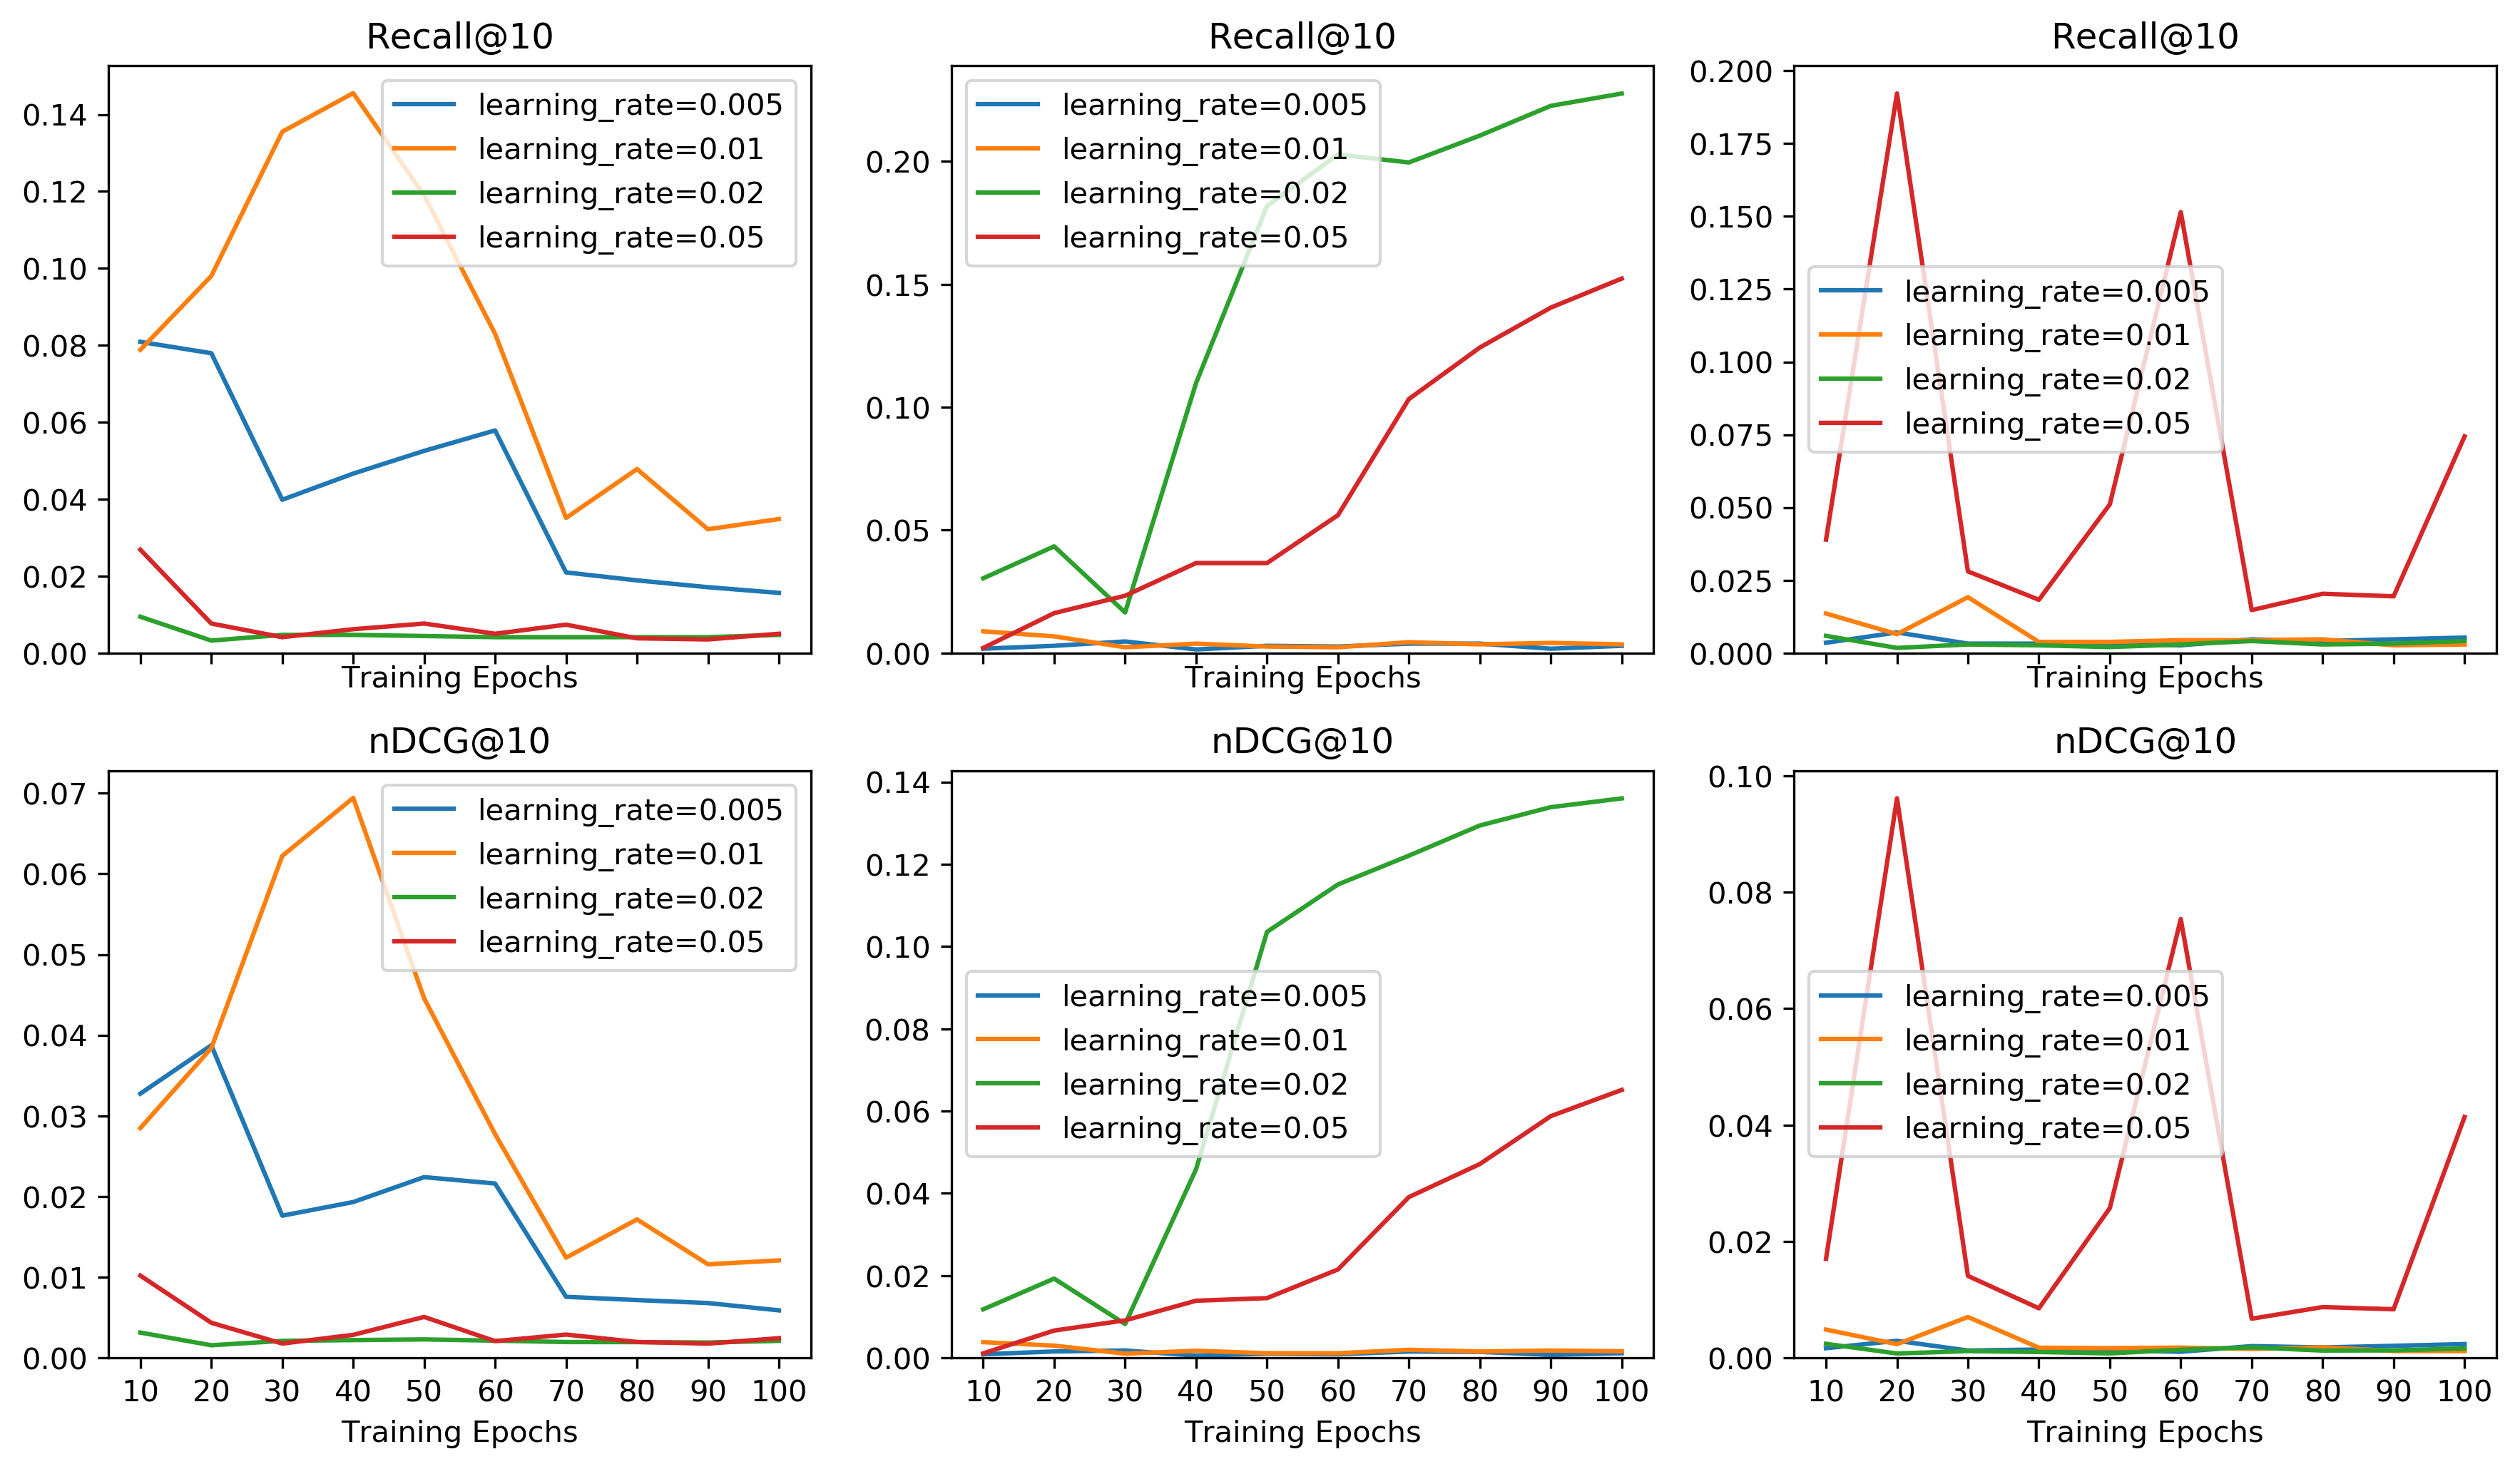

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_shared_feedforward.group_evaluations["partition"]
frappe_shared_feedforward_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = frappe_shared_feedforward_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
frappe_shared_feedforward_fig.show()

# Comparision with no semantic parts

In [17]:
frappe_cmpns = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [18]:
for e in range(10, 100 + 1, 10):
    result_path = "SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E{0}R001.tsv".format(e)
    with elapsed_timer("-- {0}s - %s" % (result_path,)):
        frappe_cmpns.add_evaluation(
            frappe_file(result_path),
            "partition", partition=int(e), algorithm="SAFM", model_params="F{0}H256L{1}B256R001".format(64, "005"))

-- 15.226802349090576s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E10R001.tsv
-- 15.216565370559692s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E20R001.tsv
-- 15.294012069702148s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E30R001.tsv
-- 15.111491918563843s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E40R001.tsv
-- 15.206868648529053s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E50R001.tsv
-- 15.090040683746338s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E60R001.tsv
-- 15.116534948348999s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E70R001.tsv
-- 15.129796743392944s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E80R001.tsv
-- 15.184372663497925s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L00

In [19]:
for e in range(10, 100 + 1, 10):
    result_path = "TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E{0}R001.tsv".format(e)
    with elapsed_timer("-- {0}s - %s" % (result_path,)):
        frappe_cmpns.add_evaluation(
            frappe_file(result_path),
            "partition", partition=int(e), algorithm="SAFM w/o semantic", model_params="F64H128L02B256R001")

-- 15.257818698883057s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E10R001.tsv
-- 15.209073781967163s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E20R001.tsv
-- 15.200546264648438s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E30R001.tsv
-- 15.201812744140625s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E40R001.tsv
-- 15.093130588531494s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E50R001.tsv
-- 15.209966659545898s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E60R001.tsv
-- 15.256333112716675s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E70R001.tsv
-- 15.160468578338623s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E80R001.tsv
-- 15.20510983467102s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E90R001.tsv
-- 15.203064680099487s - TAFMsingle/F64H128L02B256R001/TAFMsingle_F64H128L02B256E100R001.tsv


In [20]:
frappe_cmpns.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.003159      0.031591        0.005744    0.012825   46.547423   
1          0.012046      0.120461        0.021902    0.059542   33.065336   
2          0.021878      0.218778        0.039778    0.127215   26.466712   
3          0.024830      0.248302        0.045146    0.142356   23.776933   
4          0.023797      0.237969        0.043267    0.150729   26.251861   
5          0.026336      0.263360        0.047884    0.151968   24.526584   
6          0.027547      0.275465        0.050085    0.155388   22.074586   
7          0.028078      0.280779        0.051051    0.158053   22.598263   
8          0.025391      0.253912        0.046166    0.127375   23.340800   
9          0.025775      0.257750        0.046864    0.118866   23.994180   
10         0.015117      0.151166        0.027485    0.085641   31.132192   
11         0.025066      0.250664        0.045575    0.133879   24.662276   
12         0.019722      0.197225        0.035859    0.084876   28.031059   
13         0.008710      0.087098        0.015836    0.039872   34.510703   
14         0.005610      0.056097        0.010199    0.026372   41.617937   
15         0.004281      0.042811        0.007784    0.018041   44.581818   
16         0.002657      0.026572        0.004831    0.009908   49.108645   
17         0.002539      0.025391        0.004617    0.009337   53.142320   
18         0.002037      0.020372        0.003704    0.007374   55.925156   
19         0.001712      0.017124        0.003114    0.006292   58.397141   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0                   1.0                   1.0   
1             0.0                   1.0                   1.0   
2             0.0                   1.0                   1.0   
3             0.0                   1.0                   1.0   
4             0.0                   1.0                   1.0   
5             0.0                   1.0                   1.0   
6             0.0                   1.0                   1.0   
7             0.0                   1.0                   1.0   
8             0.0                   1.0                   1.0   
9             0.0                   1.0                   1.0   
10            0.0                   1.0                   1.0   
11            0.0                   1.0                   1.0   
12            0.0                   1.0                   1.0   
13            0.0                   1.0                   1.0   
14            0.0                   1.0                   1.0   
15            0.0                   1.0                   1.0   
16            0.0                   1.0                   1.0   
17            0.0                   1.0                   1.0   
18            0.0                   1.0                   1.0   
19            0.0                   1.0                   1.0   

    perc_user_events_rank_NA  partition          algorithm  \
0                   0.713611         10               SAFM   
1                   0.674638         20               SAFM   
2                   0.565397         30               SAFM   
3                   0.534101         40               SAFM   
4                   0.524063         50               SAFM   
5                   0.478004         60               SAFM   
6                   0.465604         70               SAFM   
7                   0.456156         80               SAFM   
8                   0.446413         90               SAFM   
9                   0.441984        100               SAFM   
10                  0.568940         10  SAFM w/o semantic   
11                  0.439622         20  SAFM w/o semantic   
12                  0.420136         30  SAFM w/o semantic   
13                  0.420726         40  SAFM w/o semantic   
14                  0.430469         50  SAFM w/o semantic   
15                  0.464128

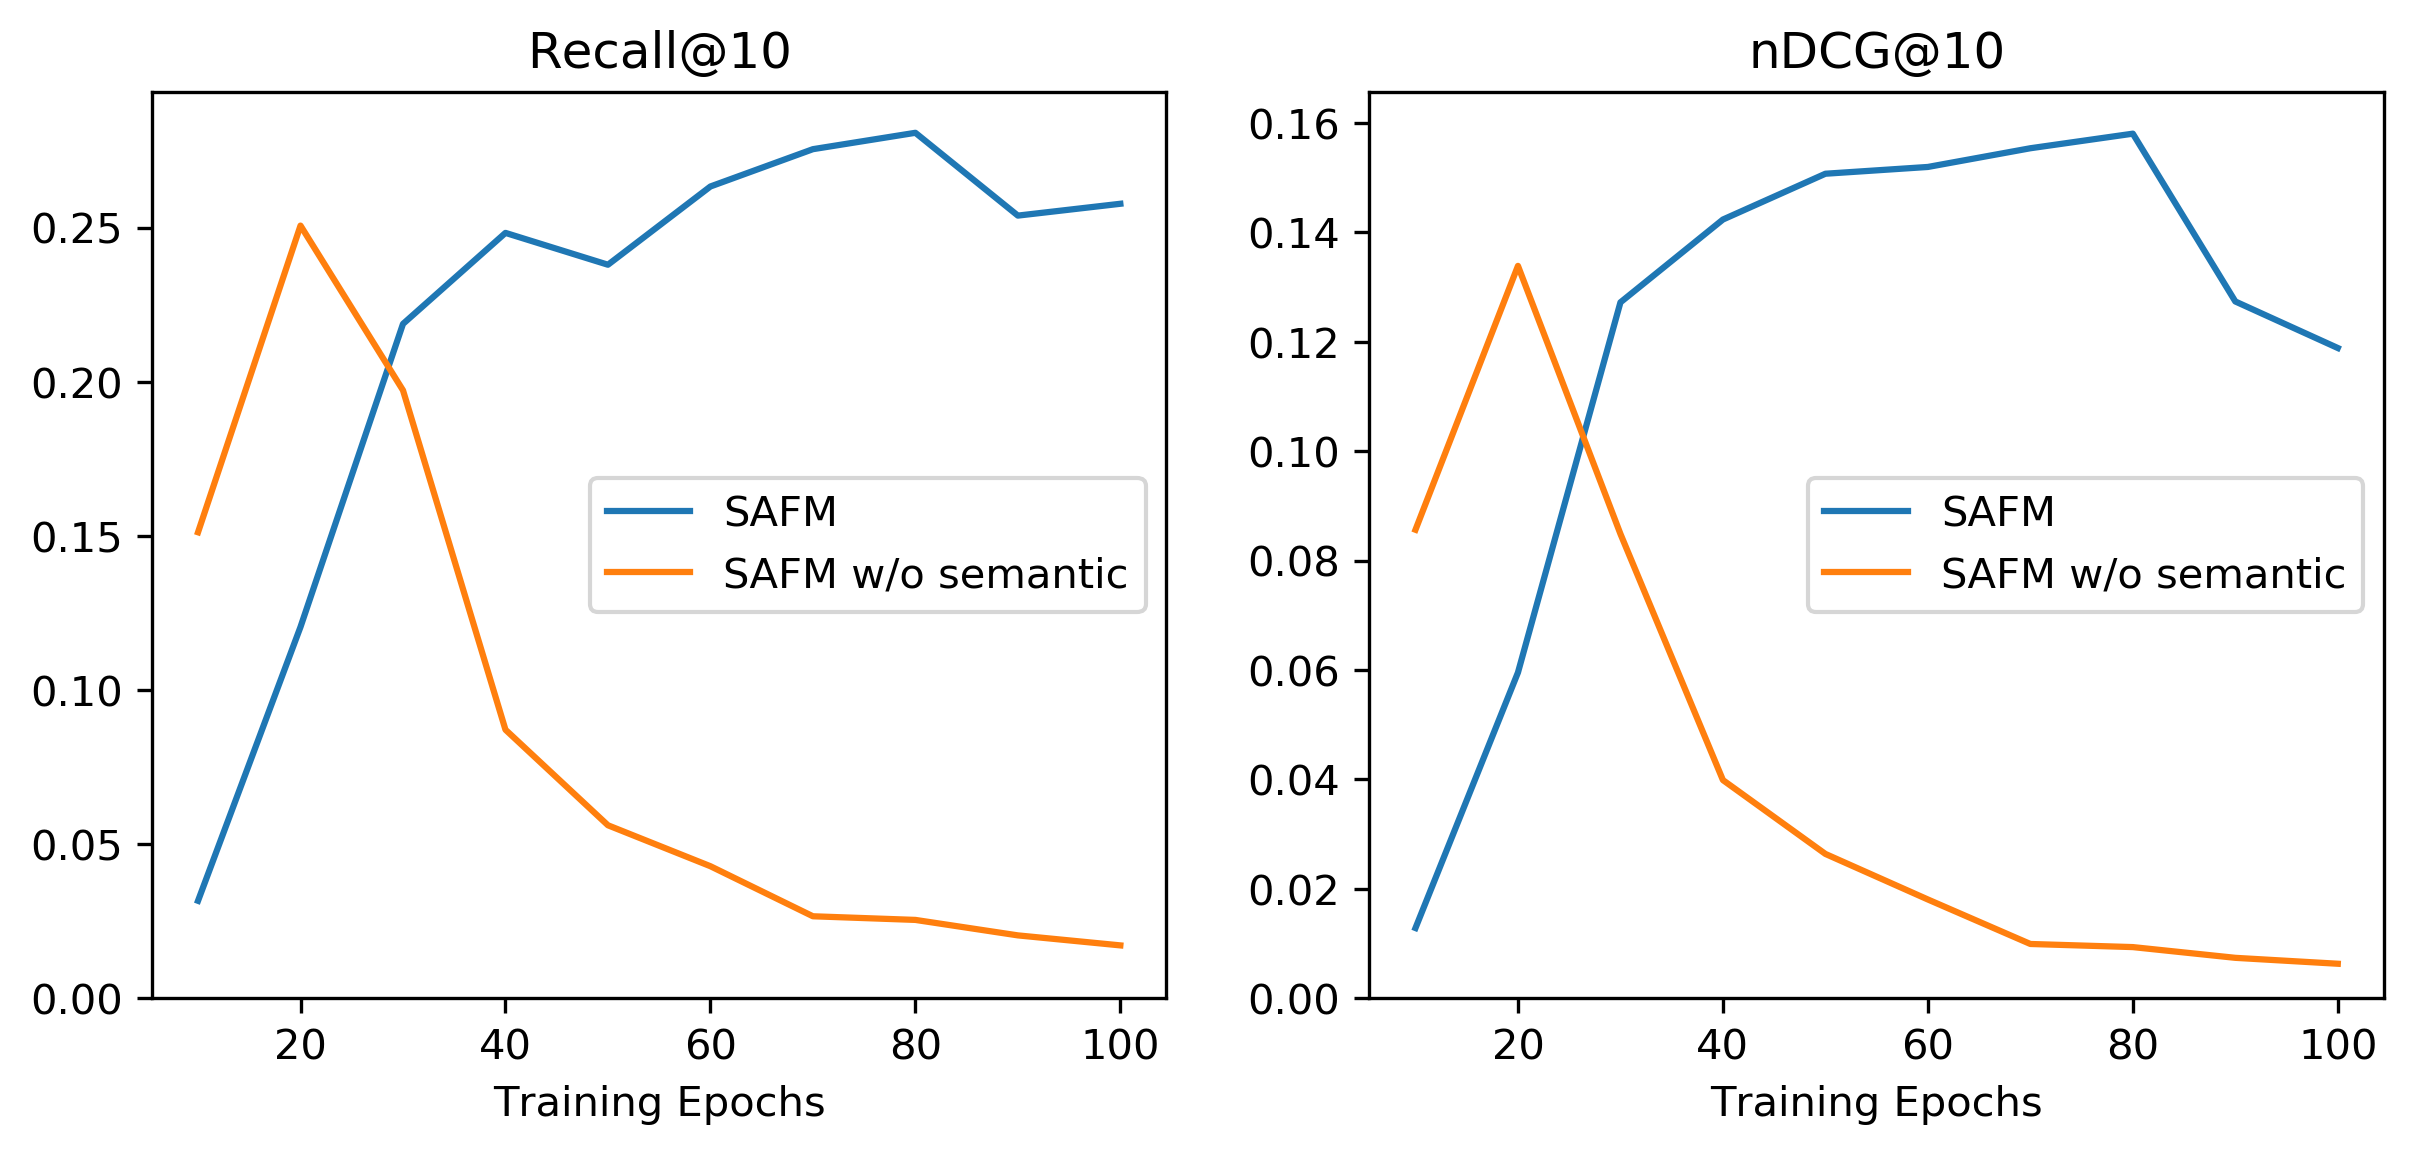

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_cmpns.group_evaluations["partition"]
frappe_cmpns_fig = plt.figure(figsize=[9.6, 4.0], dpi=300)
ax_recall, ax_ndcg = frappe_cmpns_fig.subplots(nrows=1, ncols=2, sharex="col")


ax_recall.set_title("Recall@10")
ax_recall.set_xlabel("Training Epochs")
for algo in ["SAFM", "SAFM w/o semantic"]:
    index = (dataframe["algorithm"] == algo)
    ax_recall.plot(dataframe.loc[index, "partition"],
                   dataframe.loc[index, "recall_at_10"],
                  label=algo)
ax_recall.set_ylim(bottom=0.0)
ax_recall.legend()

ax_ndcg.set_title("nDCG@10")
ax_ndcg.set_xlabel("Training Epochs")
for algo in ["SAFM", "SAFM w/o semantic"]:
    index = (dataframe["algorithm"] == algo)
    ax_ndcg.plot(dataframe.loc[index, "partition"],
                 dataframe.loc[index, "ndcg_at_10"],
                 label=algo)
ax_ndcg.set_ylim(bottom=0.0)
ax_ndcg.legend()

frappe_cmpns_fig.show()

# Comparision with non-shared

In [21]:
frappe_cmpnonshared = EvaluatePartition("../data/frappe/", runMetricsPerUser=quickMetricsPerUser)

users: 3387, events: 856


In [22]:
for e in range(10, 100 + 1, 10):
    result_path = "SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E{0}R001.tsv".format(e)
    with elapsed_timer("-- {0}s - %s" % (result_path,)):
        frappe_cmpnonshared.add_evaluation(
            frappe_file(result_path),
            "partition", partition=int(e), algorithm="SAFM", model_params="F64H256L005B256R001")

-- 15.375207424163818s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E10R001.tsv
-- 15.255782842636108s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E20R001.tsv
-- 15.252851247787476s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E30R001.tsv
-- 15.233834266662598s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E40R001.tsv
-- 15.347818851470947s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E50R001.tsv
-- 15.287348747253418s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E60R001.tsv
-- 15.224207639694214s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E70R001.tsv
-- 15.316765546798706s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L005B256E80R001.tsv
-- 15.261412620544434s - SAFMmp_ds/shared-attention/F64H256L005B256R001/0119/SAFMsatt_F64H256L00

In [23]:
for e in range(10, 100 + 1, 10):
    result_path = "SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E{0}R001.tsv".format(e)
    with elapsed_timer("-- {0}s - %s" % (result_path,)):
        frappe_cmpnonshared.add_evaluation(
            frappe_file(result_path),
            "partition", partition=int(e), algorithm="SAFM non-shared", model_params="F64H256L02B256R001")

-- 15.508665561676025s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E10R001.tsv
-- 15.314598083496094s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E20R001.tsv
-- 15.208867311477661s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E30R001.tsv
-- 15.245872020721436s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E40R001.tsv
-- 15.192585229873657s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E50R001.tsv
-- 15.222354888916016s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E60R001.tsv
-- 15.311447858810425s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E70R001.tsv
-- 15.44095492362976s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E80R001.tsv
-- 15.41240644454956s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E90R001.tsv
-- 15.332574844360352s - SAFMsp/shared-nothing/F64L02B256R001/SAFMsn_F64H256L02B256E100R001.tsv


In [24]:
frappe_cmpnonshared.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.003159      0.031591        0.005744    0.012825   46.547423   
1          0.012046      0.120461        0.021902    0.059542   33.065336   
2          0.021878      0.218778        0.039778    0.127215   26.466712   
3          0.024830      0.248302        0.045146    0.142356   23.776933   
4          0.023797      0.237969        0.043267    0.150729   26.251861   
5          0.026336      0.263360        0.047884    0.151968   24.526584   
6          0.027547      0.275465        0.050085    0.155388   22.074586   
7          0.028078      0.280779        0.051051    0.158053   22.598263   
8          0.025391      0.253912        0.046166    0.127375   23.340800   
9          0.025775      0.257750        0.046864    0.118866   23.994180   
10         0.016888      0.168881        0.030706    0.086916   28.261176   
11         0.028580      0.285799        0.051963    0.149792   19.867192   
12         0.030204      0.302037        0.054916    0.161801   19.710059   
13         0.030115      0.301151        0.054755    0.131258   21.609795   
14         0.029584      0.295837        0.053789    0.141466   21.654423   
15         0.028934      0.289342        0.052608    0.149042   22.896675   
16         0.028373      0.283732        0.051588    0.129774   23.631043   
17         0.027665      0.276646        0.050299    0.119699   23.486500   
18         0.025185      0.251845        0.045790    0.105859   24.104941   
19         0.023944      0.239445        0.043535    0.098667   24.398279   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0                   1.0                   1.0   
1             0.0                   1.0                   1.0   
2             0.0                   1.0                   1.0   
3             0.0                   1.0                   1.0   
4             0.0                   1.0                   1.0   
5             0.0                   1.0                   1.0   
6             0.0                   1.0                   1.0   
7             0.0                   1.0                   1.0   
8             0.0                   1.0                   1.0   
9             0.0                   1.0                   1.0   
10            0.0                   1.0                   1.0   
11            0.0                   1.0                   1.0   
12            0.0                   1.0                   1.0   
13            0.0                   1.0                   1.0   
14            0.0                   1.0                   1.0   
15            0.0                   1.0                   1.0   
16            0.0                   1.0                   1.0   
17            0.0                   1.0                   1.0   
18            0.0                   1.0                   1.0   
19            0.0                   1.0                   1.0   

    perc_user_events_rank_NA  partition        algorithm         model_params  
0                   0.713611         10             SAFM  F64H256L005B256R001  
1                   0.674638         20             SAFM  F64H256L005B256R001  
2                   0.565397         30             SAFM  F64H256L005B256R001  
3                   0.534101         40             SAFM  F64H256L005B256R001  
4                   0.524063         50             SAFM  F64H256L005B256R001  
5                   0.478004         60             SAFM  F64H256L005B256R001  
6                   0.465604         70             SAFM  F64H256L005B256R001  
7                   0.456156         80             SAFM  F64H256L005B256R001  
8                   0.446413         90             SAFM  F64H256L005B256R001  
9                   0.441984        100             SAFM  F64H256L005B256R001  
10                  0.623561         10  SAFM non-shared   F64H256L02B256R001  
11                  0.475347         20  SAFM non-shared   F

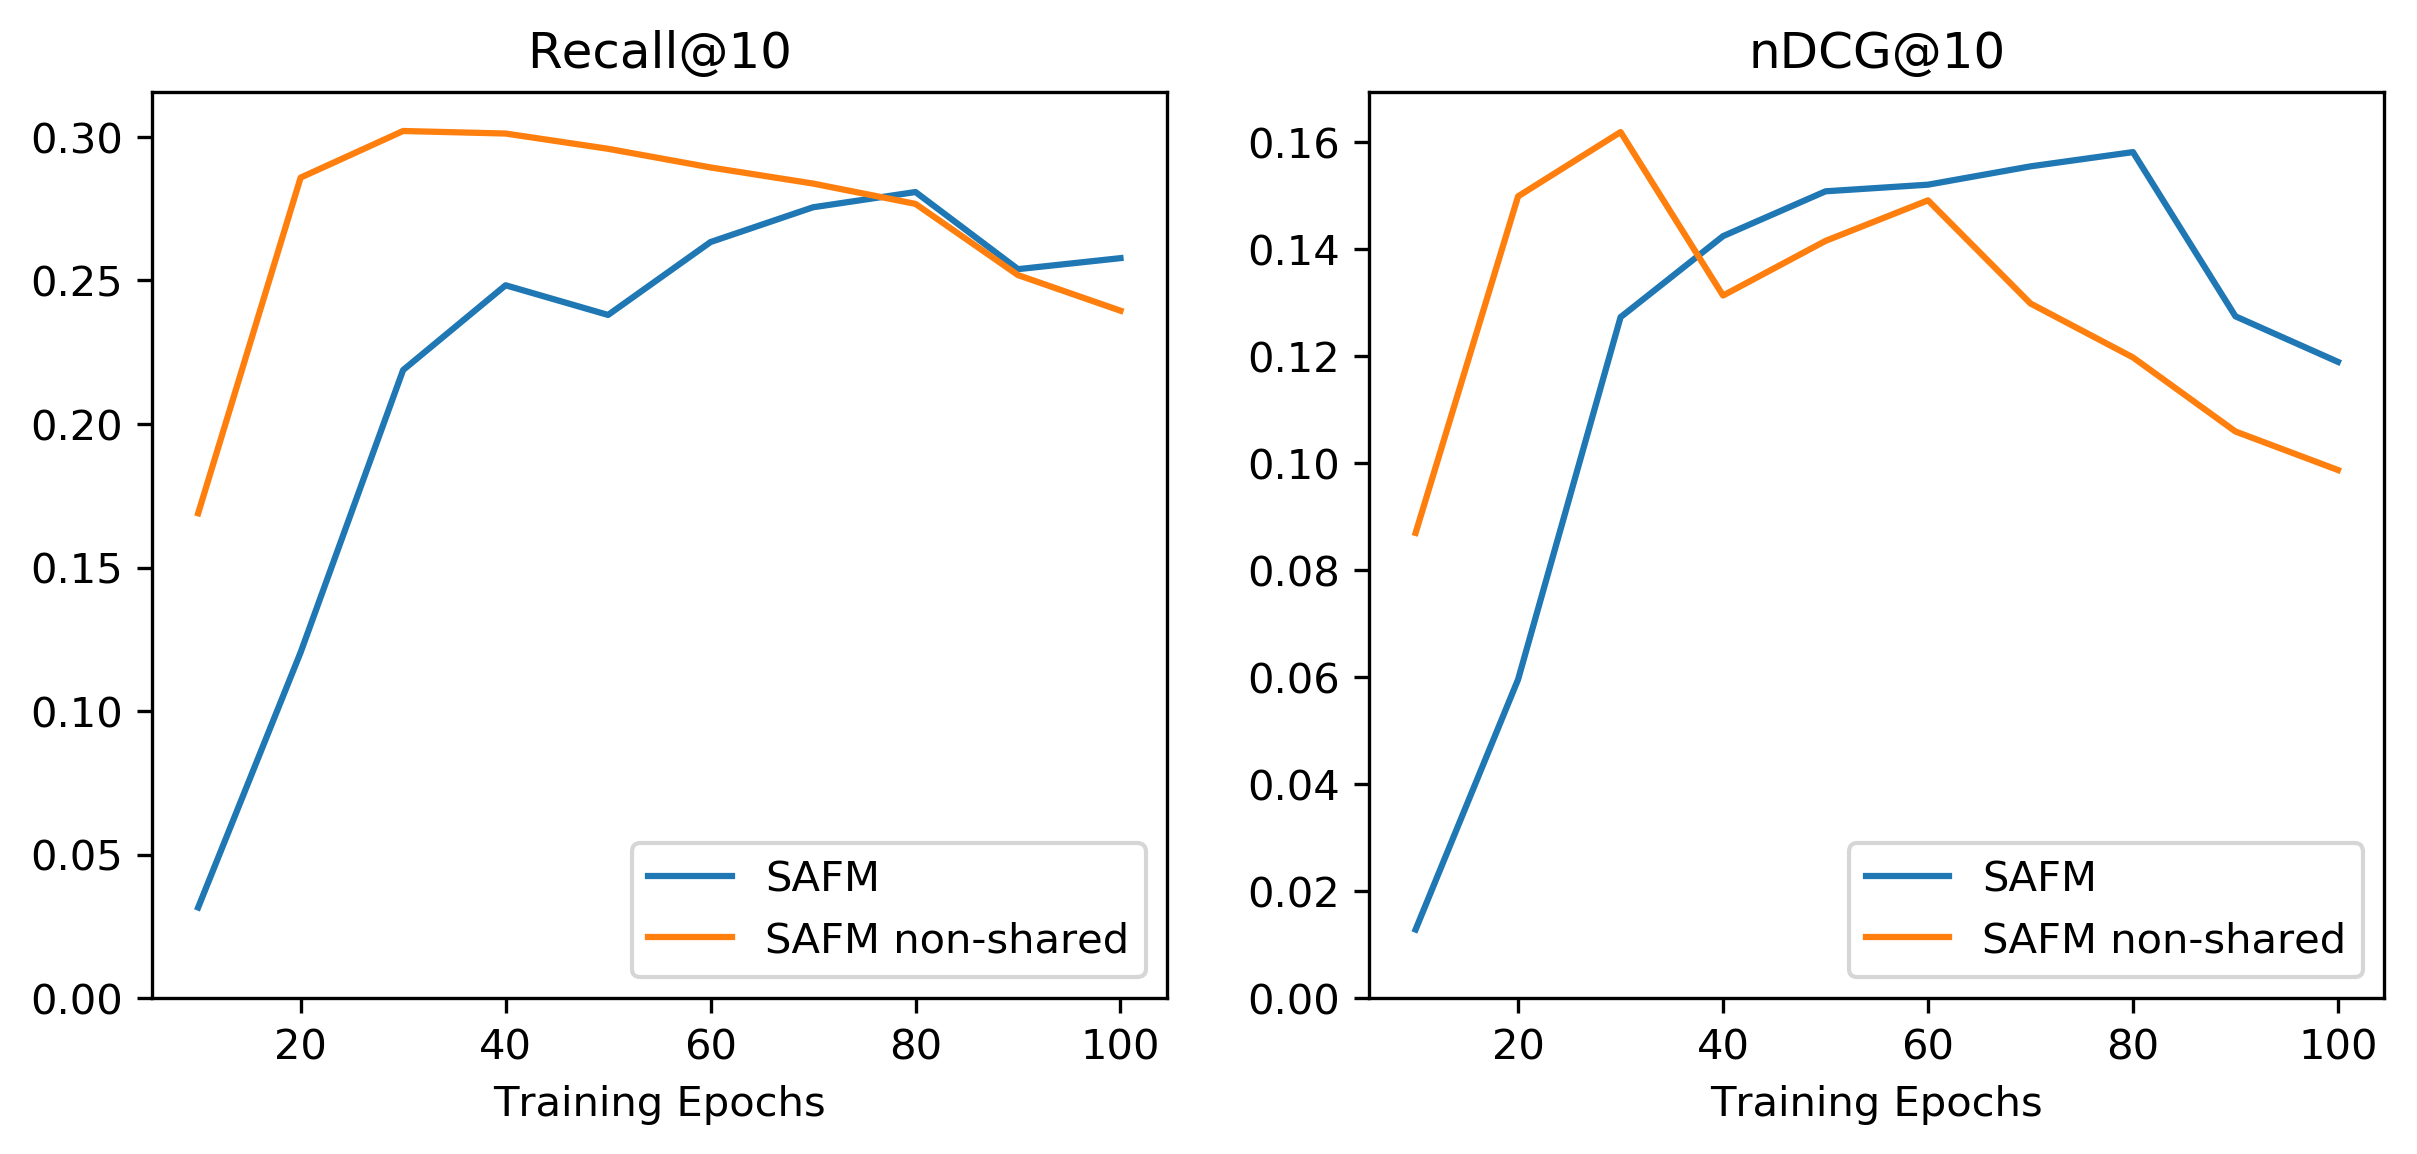

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_cmpnonshared.group_evaluations["partition"]
frappe_cmpnonshared_fig = plt.figure(figsize=[9.6, 4.0], dpi=300)
ax_recall, ax_ndcg = frappe_cmpnonshared_fig.subplots(nrows=1, ncols=2, sharex="col")


ax_recall.set_title("Recall@10")
ax_recall.set_xlabel("Training Epochs")
for algo in ["SAFM", "SAFM non-shared"]:
    index = (dataframe["algorithm"] == algo)
    ax_recall.plot(dataframe.loc[index, "partition"],
                   dataframe.loc[index, "recall_at_10"],
                  label=algo)
ax_recall.set_ylim(bottom=0.0)
ax_recall.legend()

ax_ndcg.set_title("nDCG@10")
ax_ndcg.set_xlabel("Training Epochs")
for algo in ["SAFM", "SAFM non-shared"]:
    index = (dataframe["algorithm"] == algo)
    ax_ndcg.plot(dataframe.loc[index, "partition"],
                 dataframe.loc[index, "ndcg_at_10"],
                 label=algo)
ax_ndcg.set_ylim(bottom=0.0)
ax_ndcg.legend()

frappe_cmpnonshared_fig.show()